## Time Series Forecasting of the 2018-19 NBA Season - 2014 Draft Class

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.spatial.distance import cdist
from numpy.linalg import inv
from sklearn.kernel_ridge import KernelRidge
from bs4 import BeautifulSoup
from urllib.request import urlopen
from pandas.plotting import scatter_matrix
from IPython.display import display
import seaborn as sns
from sklearn.linear_model import LinearRegression
import pymc3 as pm
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans
%matplotlib inline
from sklearn.metrics import mean_squared_error
from math import sqrt


/Users/Sachin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
"""
Scraping Data - Train
"""

# def OpptoDRtg(i):
#     url = 'https://www.basketball-reference.com/leagues/NBA_{}_ratings.html'.format(i)
#     html = urlopen(url)
#     soup = BeautifulSoup(html, 'html.parser')
#     column_headers = [th.getText() for th in 
#                 soup.findAll('th',{'class':'poptip'})]
    
#     column_headers.pop(0)
#     data_rows = soup.findAll('tr')
#     team_data = [[td.getText() for td in data_rows[i].findAll('td')]
#         for i in range(len(data_rows))]
#     tdf = pd.DataFrame(team_data, columns=column_headers)
#     tdf = tdf.drop(['Conf', 'Div', 'W', 'L', 'W/L%', 'MOV', 'ORtg', 'NRtg', 'MOV/A', 'ORtg/A', 'DRtg/A', 
#                     'NRtg/A'],axis=1)
#     tdf = tdf.drop(tdf.index[[0,1]])
#     tdf['DRtg'] = tdf['DRtg'].apply(pd.to_numeric, errors='coerce')
#     arr = np.array(tdf['DRtg'])
#     minDRtg = arr.min()
#     diffDRtg = (arr.max() - arr.min())
#     tdf.DRtg = (((tdf.DRtg - minDRtg) / diffDRtg) * 100) + 0.01
#     tdf = tdf.replace(['Houston Rockets','Toronto Raptors','Golden State Warriors','Utah Jazz',
#      'Philadelphia 76ers','Oklahoma City Thunder','Boston Celtics',
#      'San Antonio Spurs','Portland Trail Blazers','Minnesota Timberwolves',
#      'Denver Nuggets','New Orleans Pelicans','Indiana Pacers',
#      'Cleveland Cavaliers','Washington Wizards','Miami Heat',
#      'Los Angeles Clippers','Charlotte Hornets','Detroit Pistons',
#      'Milwaukee Bucks','Los Angeles Lakers','Dallas Mavericks',
#      'New York Knicks','Brooklyn Nets','Orlando Magic','Atlanta Hawks',
#      'Memphis Grizzlies','Chicago Bulls','Sacramento Kings','Phoenix Suns'],         
#       ['HOU', 'TOR','GSW', 'UTA','PHI', 'OKC', 'BOS', 'SAS', 'POR', 'MIN',
#       'DEN', 'NOP', 'IND', 'CLE', 'WAS', 'MIA', 'LAC', 'CHO', 'DET', 'MIL', 'LAL',
#       'DAL', 'NYK', 'BRK', 'ORL', 'ATL', 'MEM', 'CHI', 'SAC', 'PHO'])
#     team_list = list(tdf.Team)
#     drtg_list = list(tdf.DRtg)
#     return team_list, drtg_list


# #print(players)

# playerDF = []

# for player in players:
#     full_player_data = pd.DataFrame()
#     for i in range(2016,2019):
#         url = 'https://www.basketball-reference.com/players/{0}/gamelog/{1}'.format(player, i)
#         html = urlopen(url)
#         soup = BeautifulSoup(html, 'html.parser')
#         column_headers = [th.getText() for th in 
#                 soup.findAll('th',{'class':'poptip'})]

#         data_rows = soup.findAll('tr', {'id':['pgl_basic.{}'.format(x) for x in range (2000)]})
#         player_data =[[td.getText() for td in data_rows[i].findAll('td')]
#             for i in range(len(data_rows))]
        
        

#         column_headers.pop(0)
#         # print(column_headers)
#         df = pd.DataFrame(player_data, columns=column_headers)
#         df = df.drop(['Tm', '\xa0','\xa0'],axis=1)
#         df = df[:].fillna(0)
#         df['MP'] = df['MP'].str[:-3]
#         df['Age'] = df['Age'].str[:2]
#         df['Date'] = df['Date'].str[:4]
#         df.columns = df.columns.str.replace('%', '_Perc')
#         opp_list, drtg_list = OpptoDRtg(i)
#         df = df.replace(opp_list,drtg_list)
#         df['Opp'] = df['Opp'].apply(pd.to_numeric, errors='coerce')
#         df['Opp'] = df['Opp'].round(2)
#         full_player_data = full_player_data.append(df, ignore_index=True)
#     playerDF.append(full_player_data)
    
    
# #display(full_player_data.head())
# display(playerDF[0].head())

# # for i in range(len(playerDF)):
# #     playerDF[i].to_csv('2014-draft-class/player{}.csv'.format(i))




'\nScraping Data - Train\n'

In [3]:
players = pd.read_csv('draft_class_2014.csv')
players = np.array(players).flatten()

playerDF  = []
for i in range(27):
    df = pd.read_csv('2014-draft-class/player{}.csv'.format(i))
    df = df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1)
    playerDF.append(df)

display(playerDF[24].head())

#test data
player2019DF = []

for i in range(27):
    df = pd.read_csv('2014-draft-class/player2019_{}.csv'.format(i))
    df = df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1)
    player2019DF.append(df)

G  Date  Age    Opp  GS  MP  FG  FGA  FG_Perc  3P ...   DRB  TRB  AST  STL  \
0  1  2015   20  74.33   0   3   1    1    1.000   0 ...     0    0    0    0   
1  2  2015   20  89.27   0  18   5    8    0.625   0 ...     6    9    1    0   
2  3  2015   20  51.92   0  24   4    9    0.444   0 ...     1    4    0    0   
3  4  2015   20  40.71   0  17   1    4    0.250   0 ...     2    3    0    0   
4  5  2015   20  37.13   0  17   2    4    0.500   0 ...     2    4    1    1   

   BLK  TOV  PF  PTS  GmSc  +/-  
0    0    1   0    2   0.7    1  
1    0    2   3   10   7.8   10  
2    0    1   2    8   3.9   -2  
3    1    1   1    5   2.8   -6  
4    1    1   1    4   4.2   -5  

[5 rows x 26 columns]

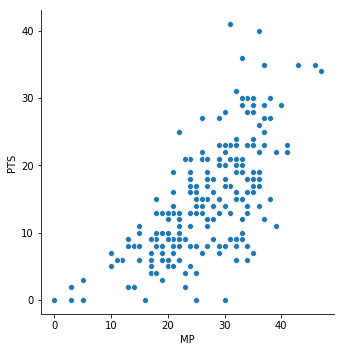

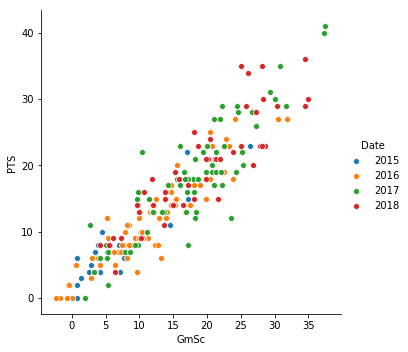

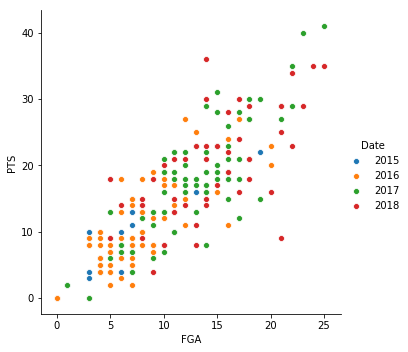

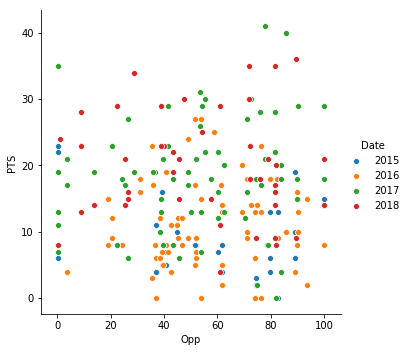

In [4]:
# for i in range(len(playerDF)):
#     playerDF[i].to_csv('2014-draft-class/player{}.csv'.format(i))

sns.pairplot(playerDF[24], x_vars =['MP'], y_vars=['PTS'],height=5)
plt.savefig('pairplot1.png')

sns.pairplot(playerDF[24], x_vars =['GmSc'], y_vars=['PTS'],hue='Date',height=5)
plt.savefig('pairplot2.png')

sns.pairplot(playerDF[24], x_vars =['FGA'], y_vars=['PTS'],hue='Date',height=5)
plt.savefig('pairplot3.png')

sns.pairplot(playerDF[24], x_vars =['Opp'], y_vars=['PTS'],hue='Date',height=5)
plt.savefig('pairplot4.png')

/Users/Sachin/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


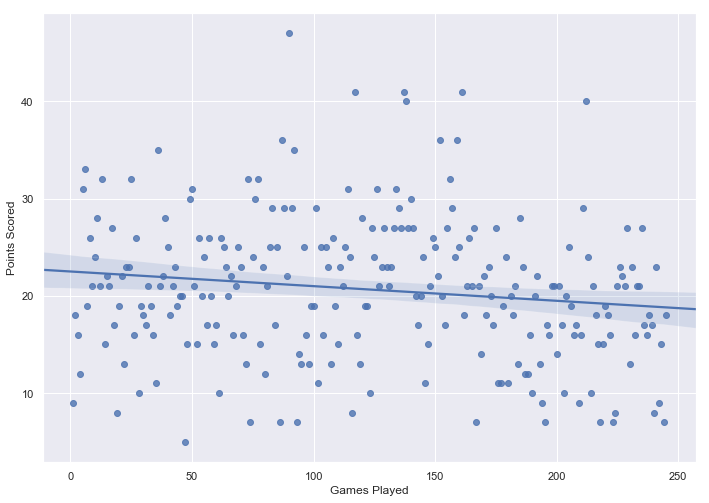

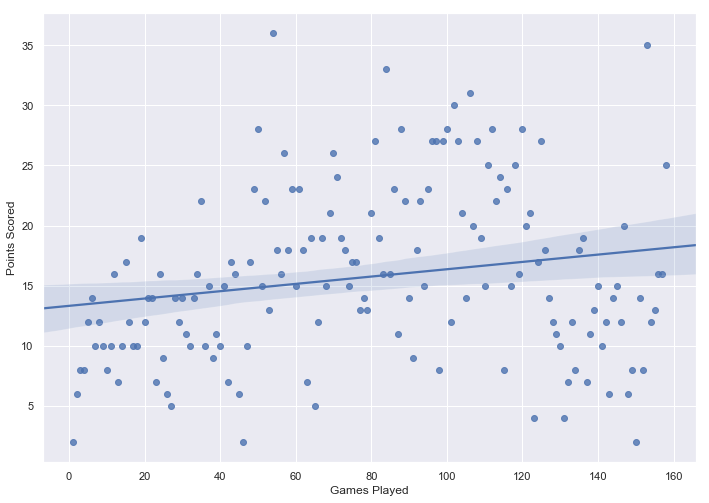

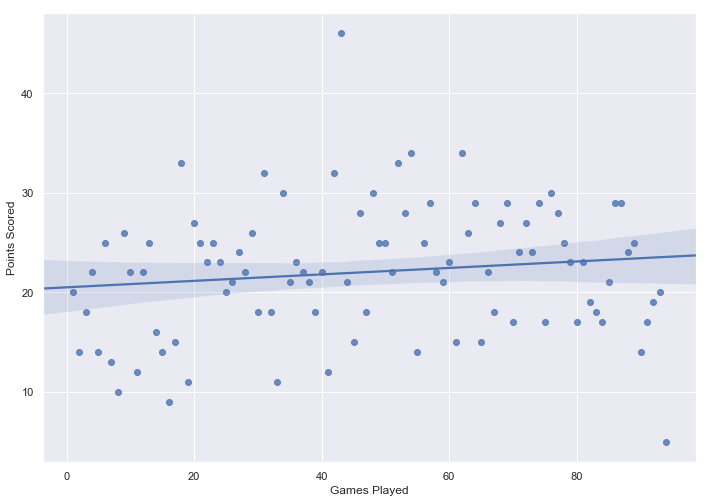

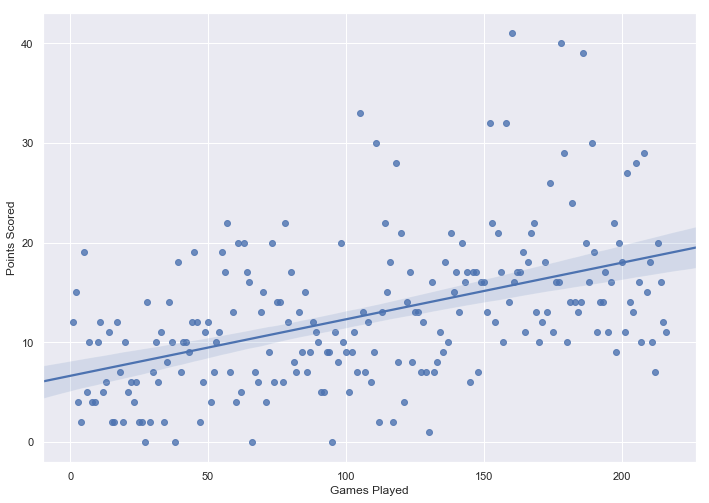

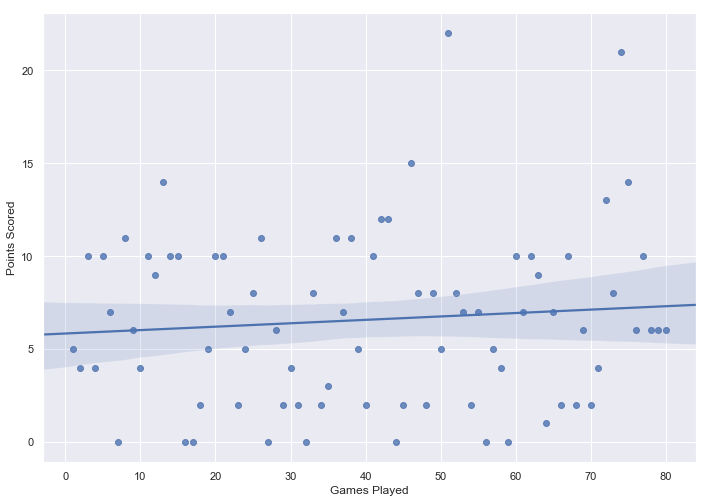

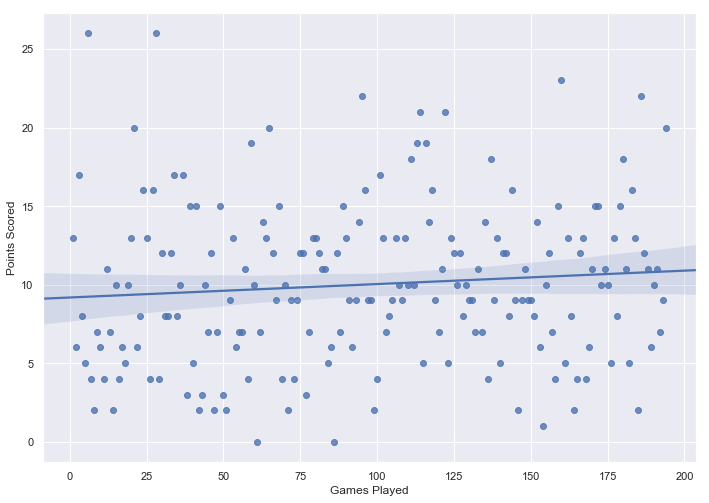

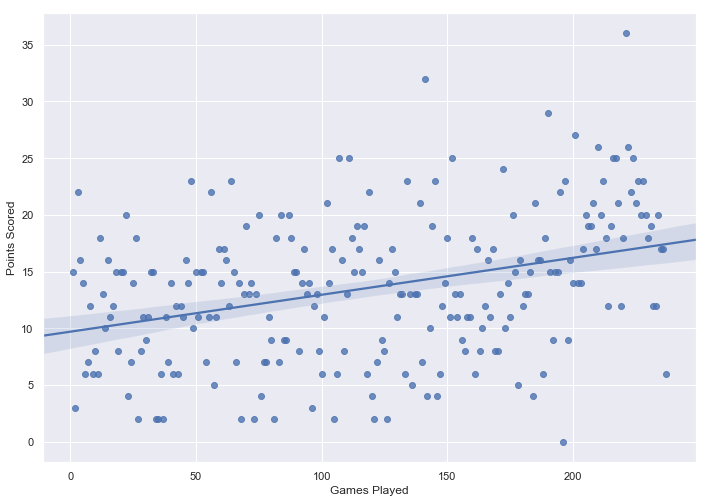

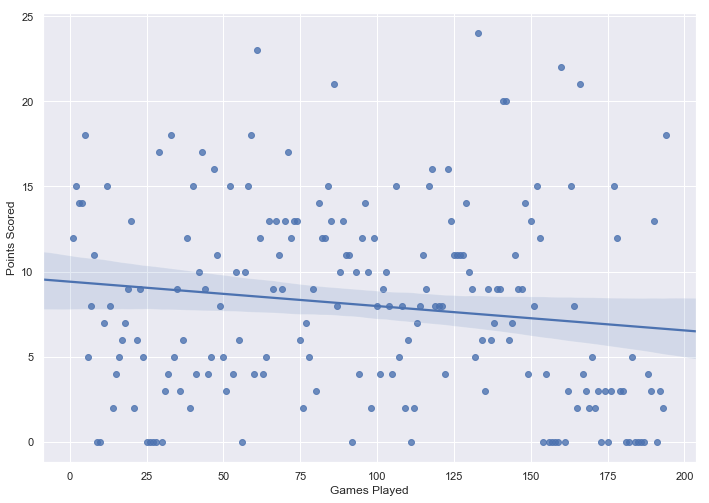

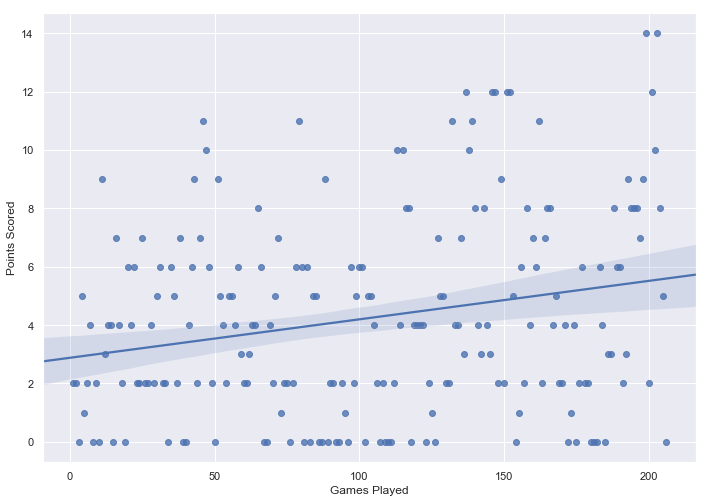

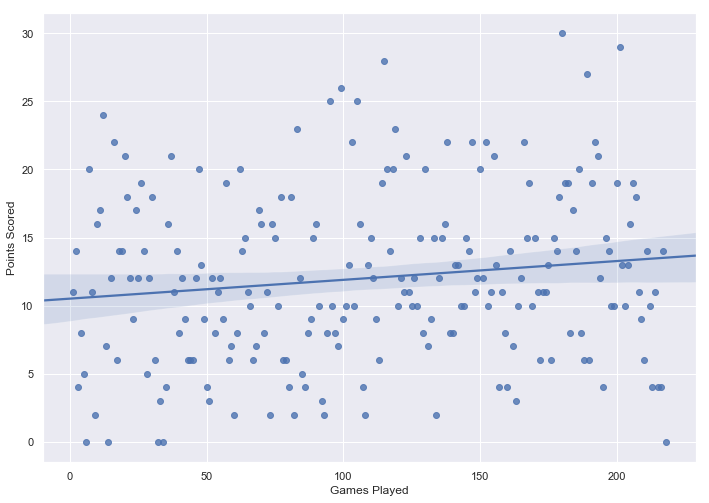

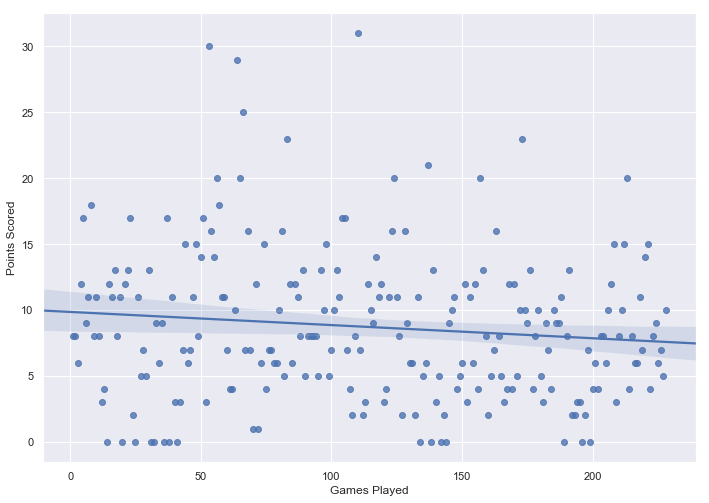

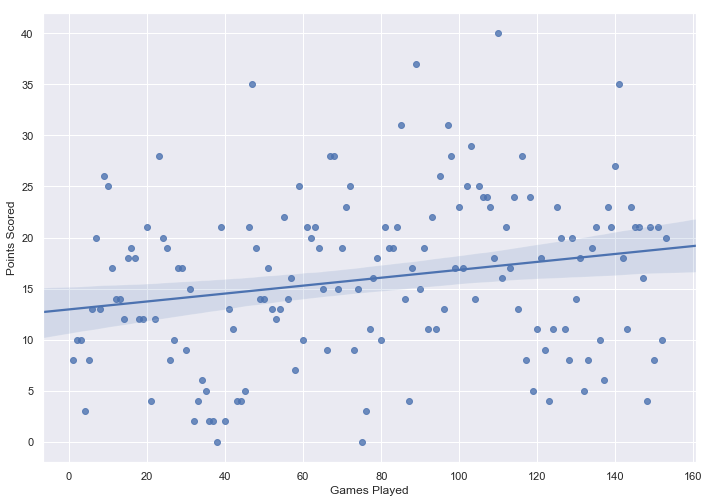

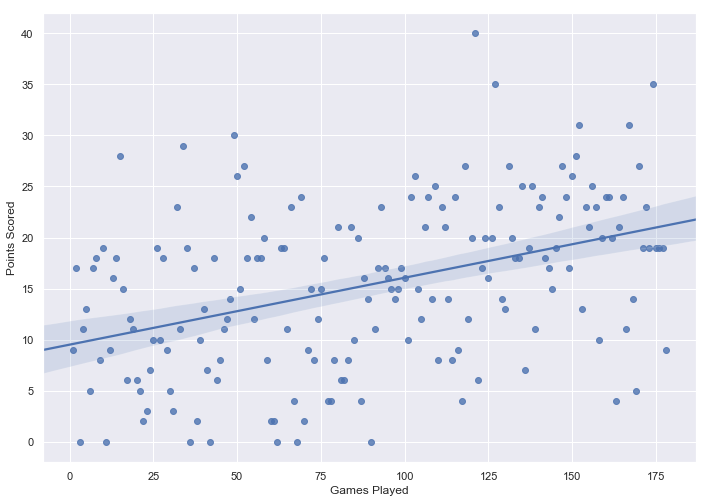

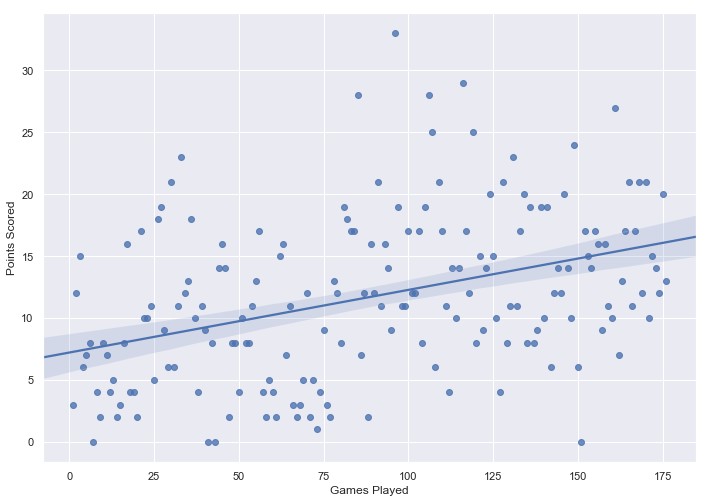

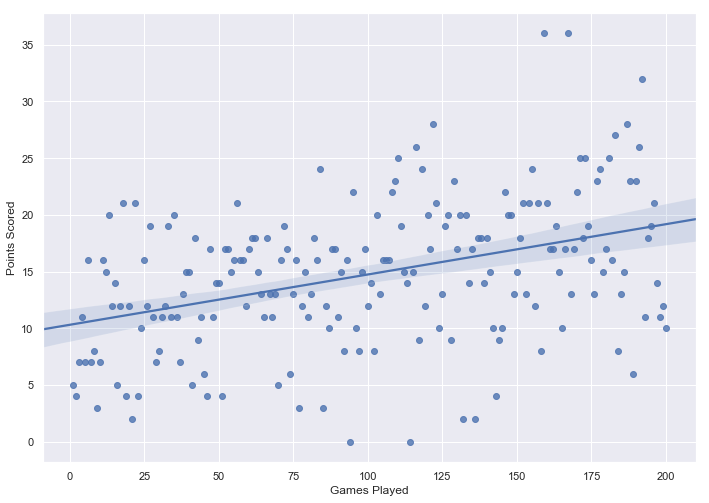

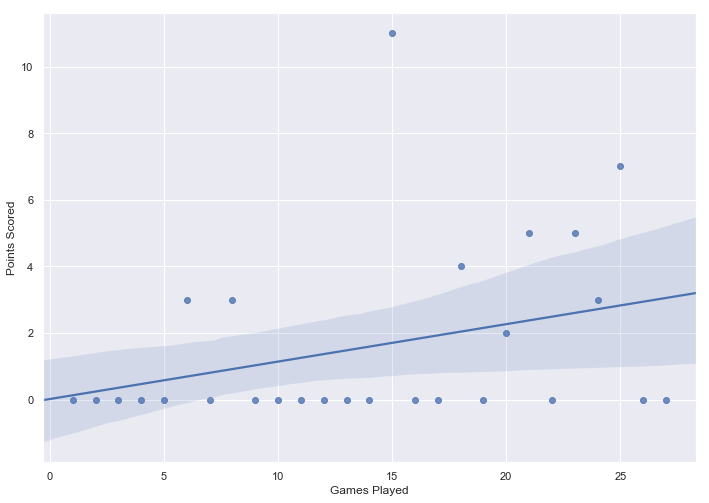

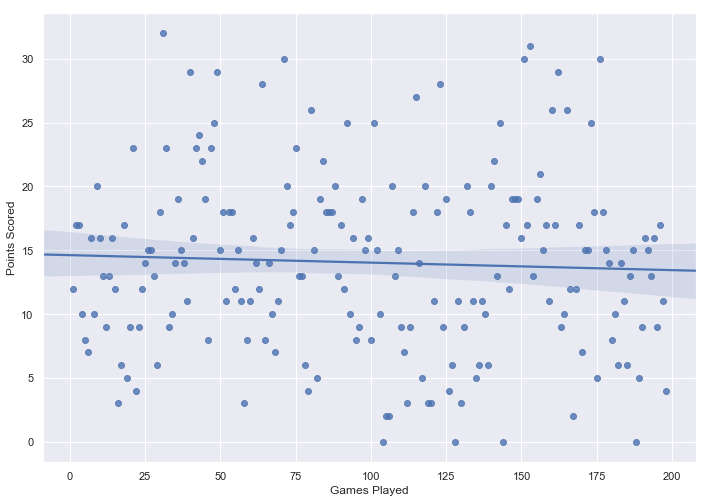

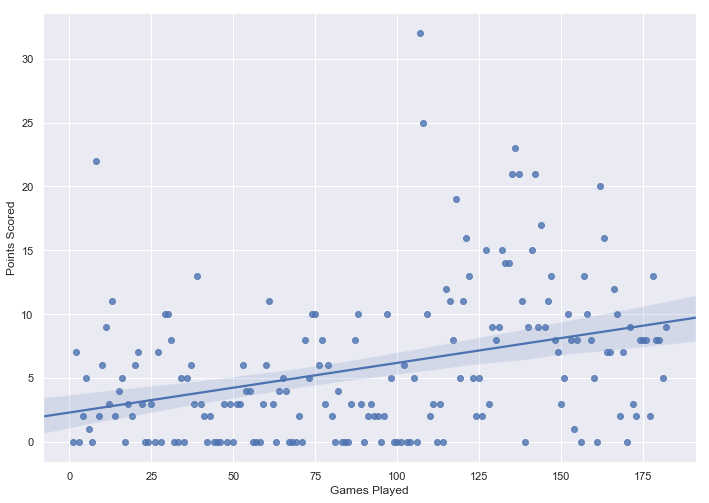

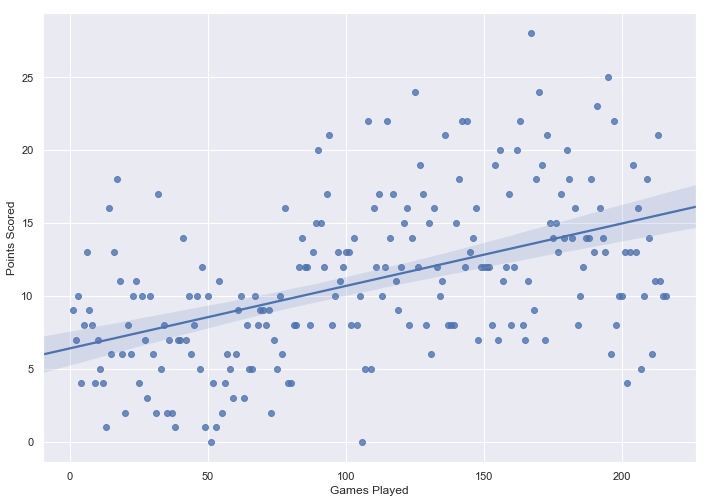

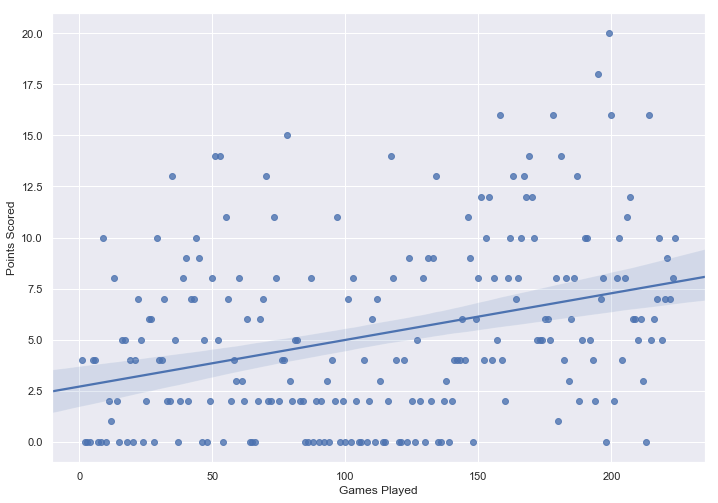

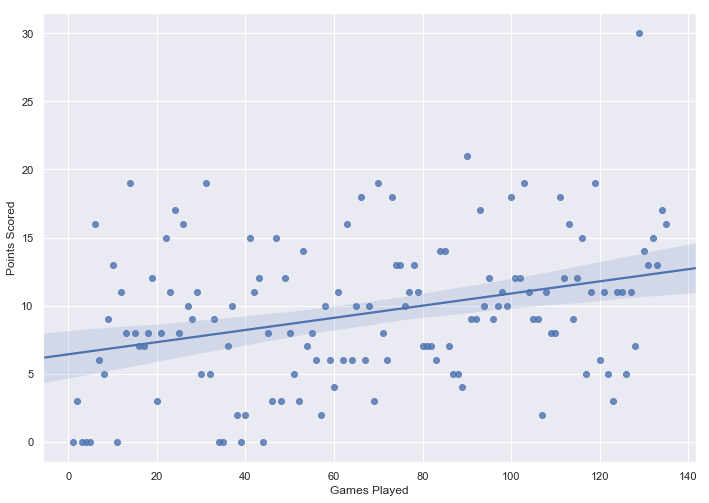

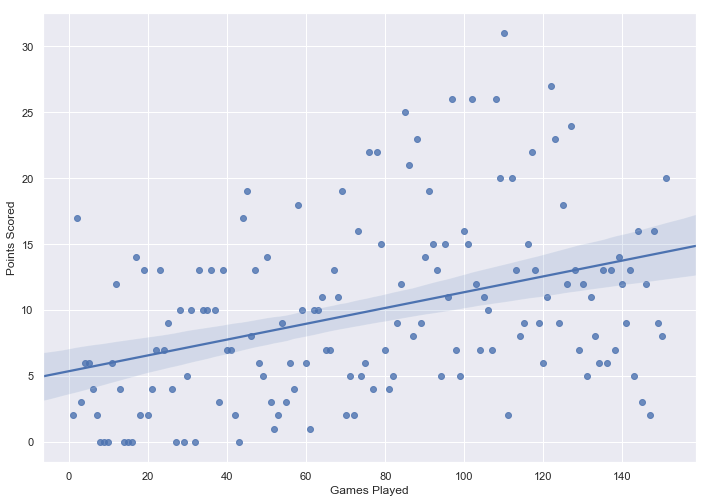

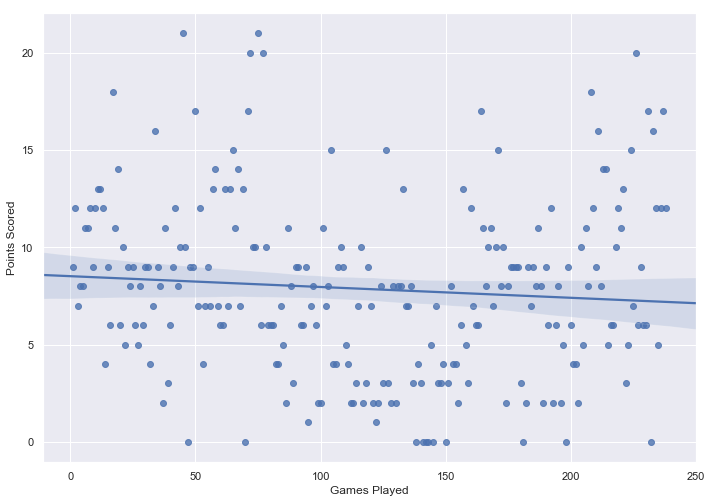

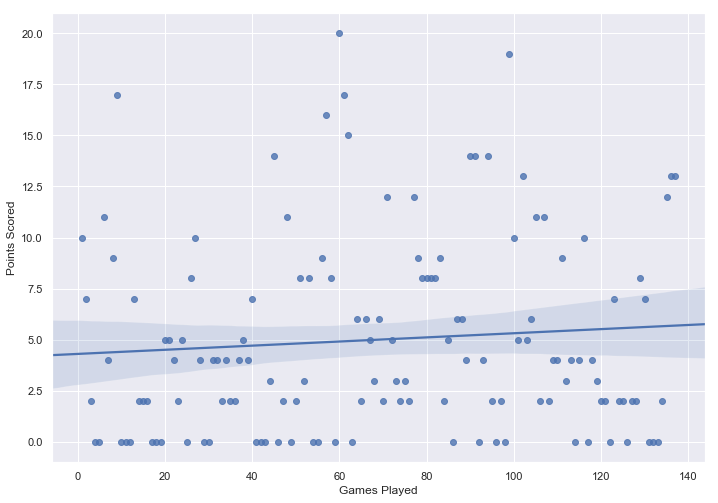

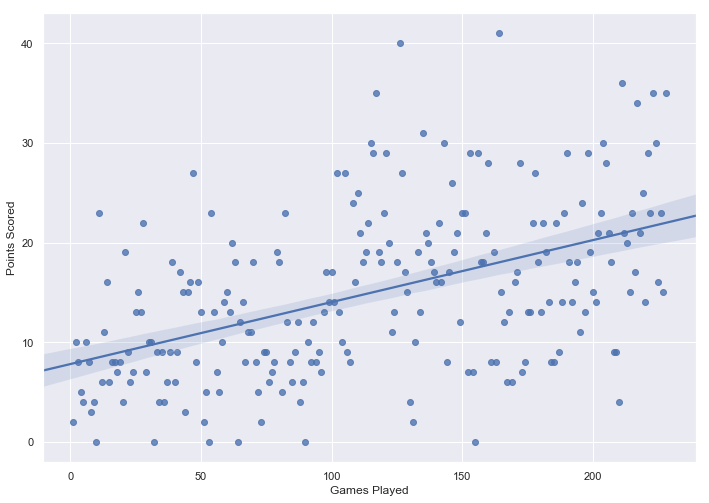

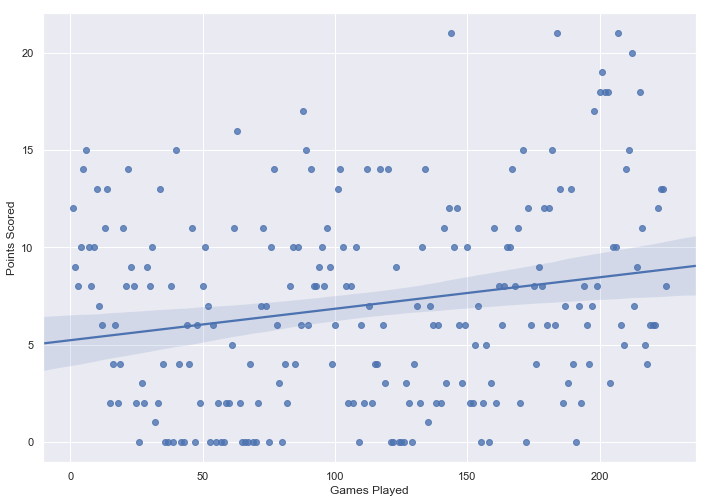

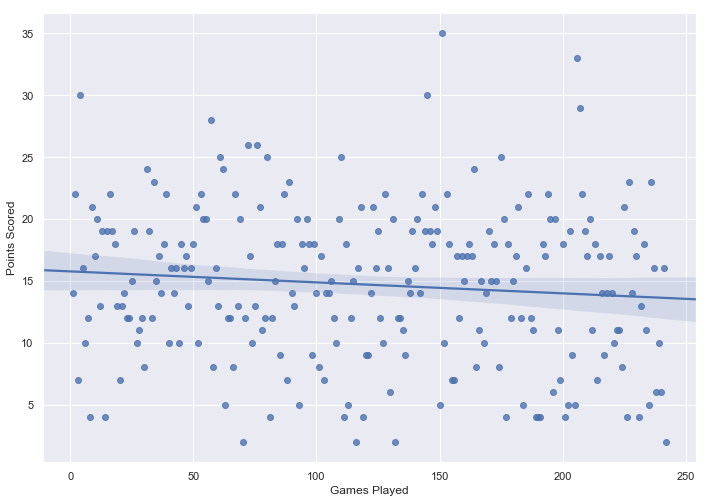

In [5]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

for i in range(len(playerDF)):
    plt.figure(i)
    gamesPl = playerDF[i].shape[0]
    x = np.arange(1,gamesPl  + 1)
    y = np.array(playerDF[i]['PTS']).astype(int)
    sns.regplot(x,y)
    plt.xlabel("Games Played")
    plt.ylabel("Points Scored")
    plt.savefig("players/player{}.png".format(i))

In [6]:
def train_classifier(clf, X, y):
    clf.fit(X,y)
#     plt.plot(X,y)
    arr = clf.predict(X)
    arr = np.around(arr)
    plt.plot(X, clf.predict(X))

    
def train_and_predict(clf, X_train, y_train, X_test,j):
    clf.fit(X_train,y_train)
    arr = clf.predict(X_test)
    arr = np.around(arr)
    plt.plot(X_test, clf.predict(X_test))
    if(clf == lr):
        plt.title("Predicting PTS: Linear Regression", fontsize=18)
        plt.savefig('players_lr/player{}'.format(j))
    elif(clf == krr):
        plt.title("Predicting PTS: Kernel Ridge Regression", fontsize=18)
        plt.savefig('players_krr/player{}'.format(j))
    return arr


In [7]:
"""
Scraping Data - Test
"""


# player2019DF = []

# for player in players:
#     player_data_2019 = pd.DataFrame()
#     url = 'https://www.basketball-reference.com/players/{}/gamelog/2019'.format(player)
#     print(url)
#     html = urlopen(url)
#     soup = BeautifulSoup(html, 'html.parser')
#     column_headers = [th.getText() for th in 
#             soup.findAll('th',{'class':'poptip'})]

#     data_rows = soup.findAll('tr', {'id':['pgl_basic.{}'.format(x) for x in range (1000)]})
#     player_data =[[td.getText() for td in data_rows[i].findAll('td')]
#         for i in range(len(data_rows))]

#     column_headers.pop(0)
#     # print(column_headers)
#     df = pd.DataFrame(player_data, columns=column_headers)
#     df = df.drop(['Tm', '\xa0','\xa0'],axis=1)
#     df = df[:].fillna(0)
#     df['MP'] = df['MP'].str[:-3]
#     df['Age'] = df['Age'].str[:2]
#     df['Date'] = df['Date'].str[:4]
#     df.columns = df.columns.str.replace('%', '_Perc')
#     opp_list, drtg_list = OpptoDRtg(2019)
#     df = df.replace(opp_list,drtg_list)
#     df['Opp'] = df['Opp'].apply(pd.to_numeric, errors='coerce')
#     df['Opp'] = df['Opp'].round(2)
#     player_data_2019 = player_data_2019.append(df, ignore_index=True)
#     player2019DF.append(player_data_2019)

'\nScraping Data - Test\n'

In [8]:
# for i in range(len(player2019DF)):
#     player2019DF[i].to_csv('2014-draft-class/player2019_{}.csv'.format(i))

In [24]:
# function for simple regression models - games played vs pts scored

def obtainTrainTest(sing_playerDF, sing_player2019DF):
   
    jokic = sing_playerDF
    jokic = jokic.apply(pd.to_numeric, errors='coerce')
    jokic = jokic[jokic.PTS != 0]

    jokic = jokic['PTS']
    jokic = jokic.reset_index()

    jokic_arr = np.array(jokic.PTS)
    gamesPl = len(jokic_arr) + 1
    game = np.arange(1,gamesPl)

    #test data
    jokic2019 = sing_player2019DF.apply(pd.to_numeric, errors ='coerce')
    jokic2019 = jokic2019[jokic2019.PTS != 0]
    jokic2019 = jokic2019['PTS']
    jokic2019 = jokic2019.reset_index()
    jokic2019_arr = np.array(jokic2019.PTS)


    gamesPl_tst = len(jokic2019_arr) + 1
    game_tst = np.arange(gamesPl, gamesPl + gamesPl_tst-1)

    total = np.append(jokic_arr,jokic2019_arr)
    train = total[:gamesPl-1]
    valid = total[gamesPl-1:]

    games_tot = np.append(game,game_tst)
    games_tot
    gtrain = games_tot[:gamesPl-1]
    gvalid = games_tot[gamesPl-1:]
    return train, valid,gtrain,gvalid

def sma(train,gvalid,j):
    train = (train.reshape(1,-1).flatten())
    gvalid = (gvalid.reshape(1,-1).flatten())
    train_hat = train[-20:]
    train_avg = np.mean(train)
    y_hat = np.ones(len(gvalid))
    for i in range(len(y_hat)):
        y_hat[i] = train_avg
    plt.plot(gvalid,y_hat,color='darkorange')
    plt.savefig('players_sma/player{}.png'.format(j))
    return y_hat

def apply_model(clf):
    j = 0
    mean_rmse = []
    average_ppg = []
    for i in range(len(playerDF)):
        plt.figure(i)
        train, valid, gtrain, gvalid = obtainTrainTest(playerDF[i], player2019DF[i])
        plt.scatter(gtrain,train)
        plt.scatter(gvalid,valid)
        plt.xlabel("Games Played")
        plt.ylabel("Points Scored")
        gtrain = gtrain.reshape(-1,1)
        gvalid = gvalid.reshape(-1,1)
        train = train.reshape(-1,1)
        if(clf == sma):
            plt.title("Predicting PTS: Simple Average Model", fontsize=18)
            p = sma(train, gvalid,j)
        else:
            train_classifier(clf, gtrain, train)
            p = train_and_predict(clf, gtrain,train,gvalid,j)

        #calculate rmse for prediction vs result
        a = np.mean(p)
        average_ppg.append(a)
        rmse = sqrt(mean_squared_error(p, valid))
        mean_rmse.append(rmse)
#         print("Classifier: player {0} rmse error is: {1}".format(players[i],rmse))
        print("player {0} average ppg: {1}".format(players[i], a))
        j = j + 1
    print(np.mean(mean_rmse))
    

player w/wiggian01 average ppg: 18.333333333333332
player p/parkeja01 average ppg: 18.903846153846153
player e/embiijo01 average ppg: 24.5
player g/gordoaa01 average ppg: 20.696969696969695
player e/exumda01 average ppg: 8.0
player s/smartma01 average ppg: 11.0
player r/randlju01 average ppg: 18.73846153846154
player s/stausni01 average ppg: 8.18
player v/vonleno01 average ppg: 7.149253731343284
player p/paytoel01 average ppg: 13.933333333333334
player m/mcderdo01 average ppg: 7.2
player l/lavinza01 average ppg: 20.112903225806452
player w/warretj01 average ppg: 22.357142857142858
player n/nurkiju01 average ppg: 18.0
player h/harriga01 average ppg: 20.348837209302324
player c/cabocbr01 average ppg: 6.0
player h/hoodro01 average ppg: 14.0
player n/napiesh01 average ppg: 11.333333333333334
player c/capelca01 average ppg: 16.89090909090909
player a/anderky01 average ppg: 8.906976744186046


/Users/Sachin/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/Sachin/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


player h/harrijo01 average ppg: 12.805970149253731
player d/dinwisp01 average ppg: 15.137931034482758


/Users/Sachin/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/Sachin/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


player g/grantje01 average ppg: 7.926470588235294
player r/robingl02 average ppg: 7.0


/Users/Sachin/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/Sachin/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


player j/jokicni01 average ppg: 24.134328358208954
player p/poweldw01 average ppg: 9.84375


/Users/Sachin/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


player c/clarkjo01 average ppg: 13.18840579710145
6.3964411337207885


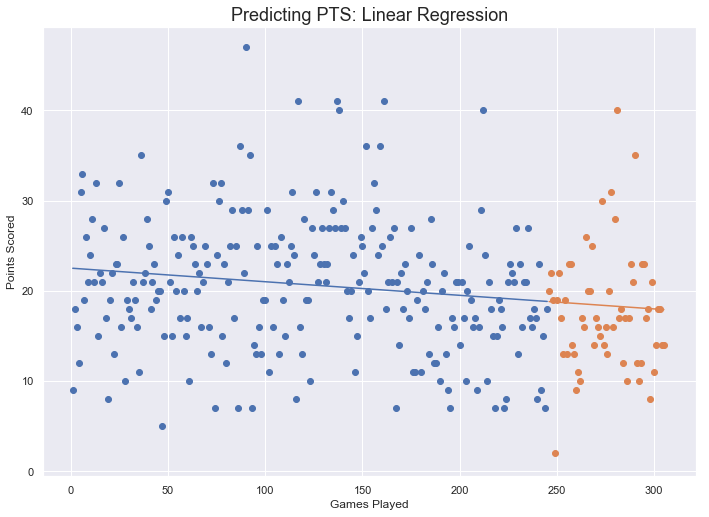

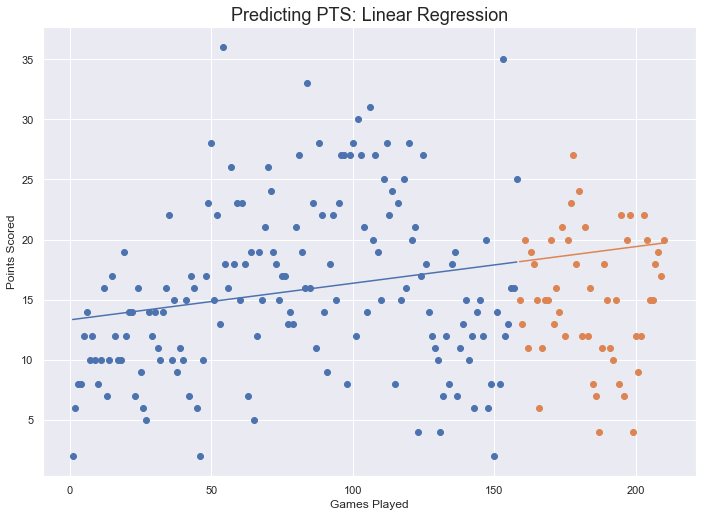

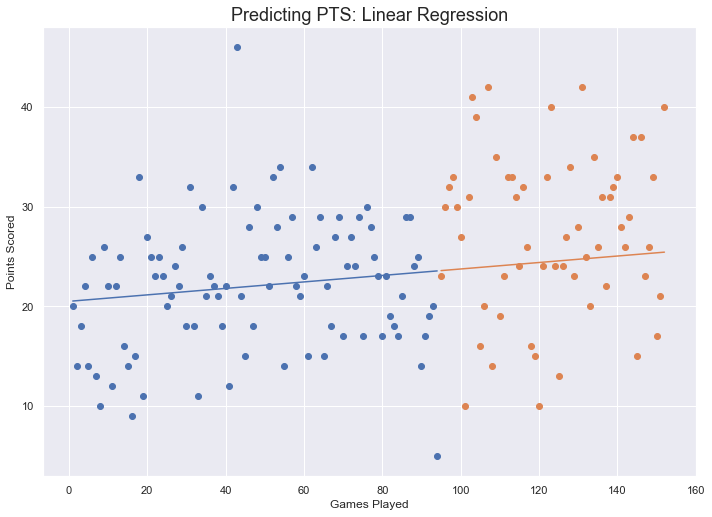

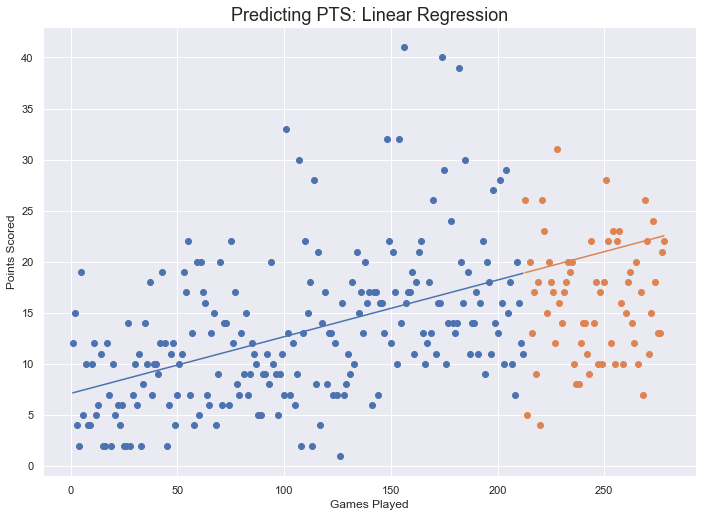

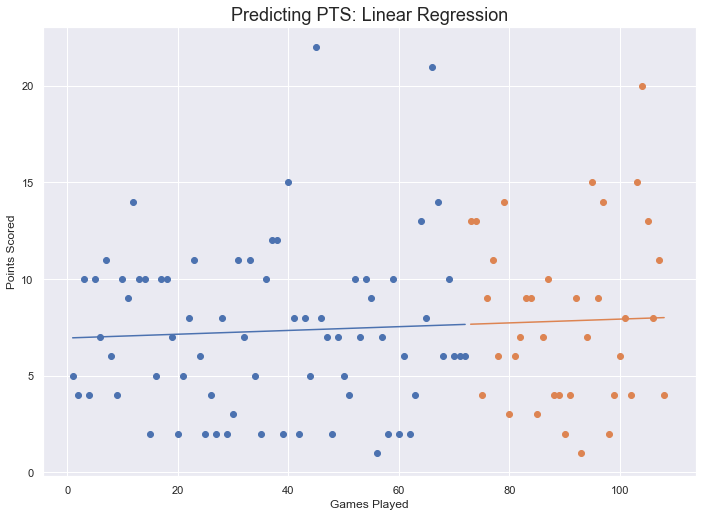

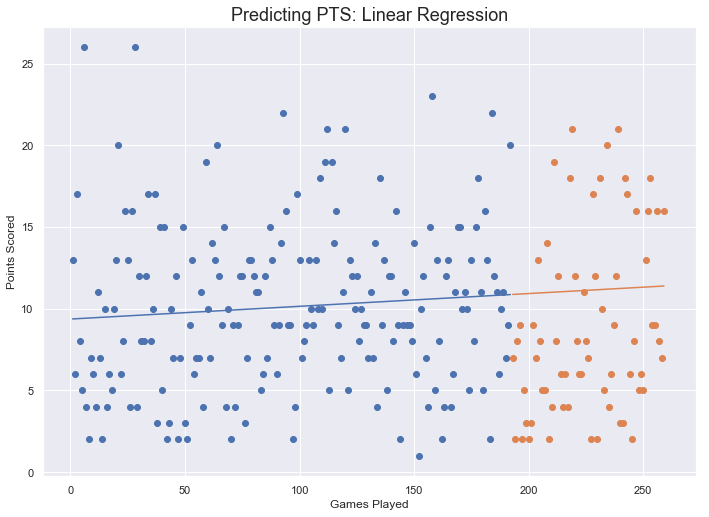

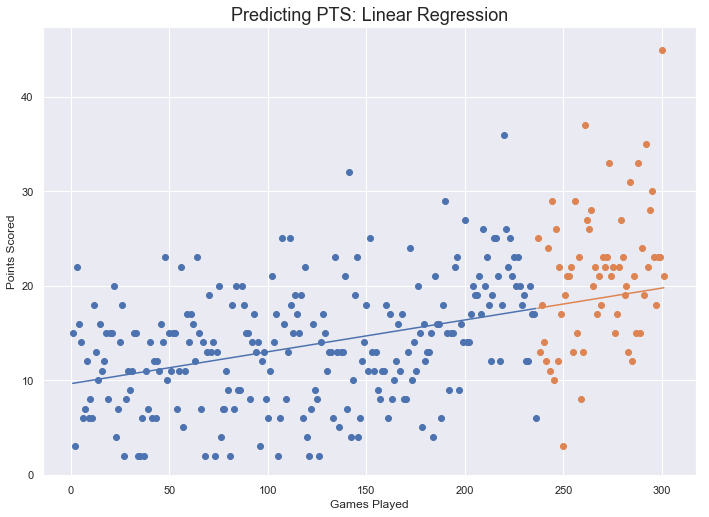

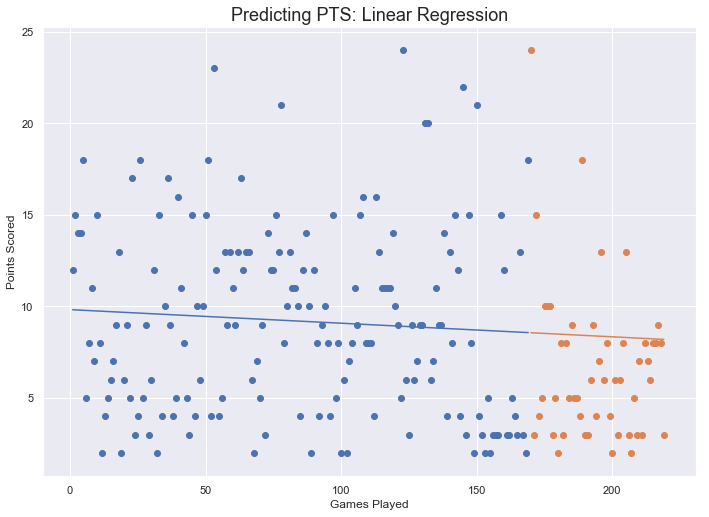

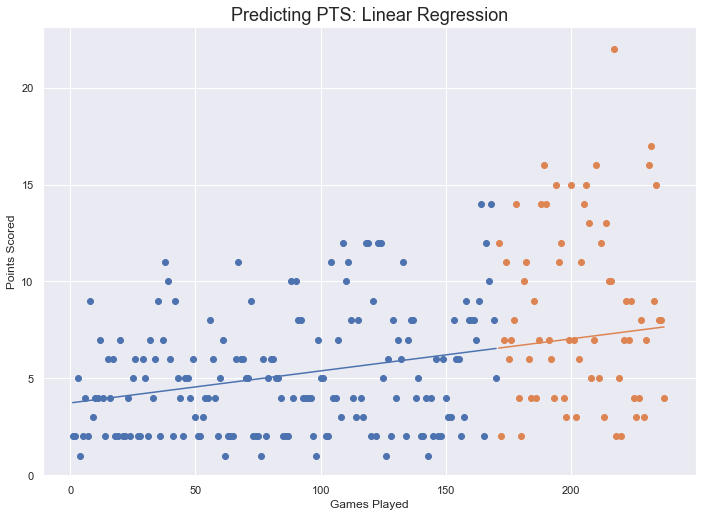

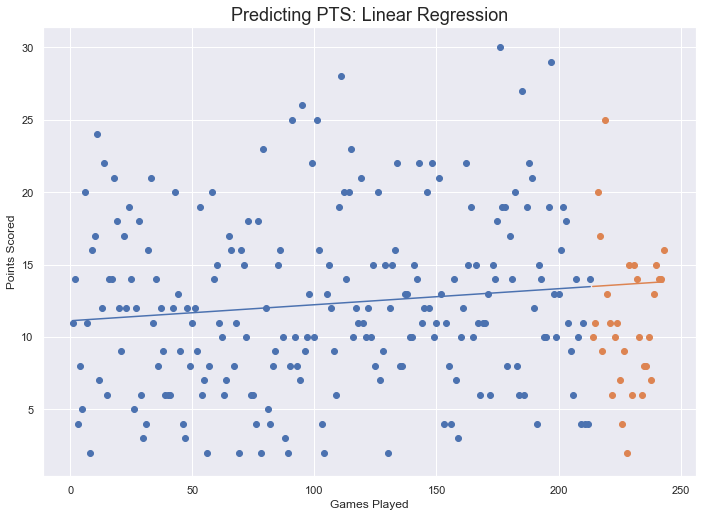

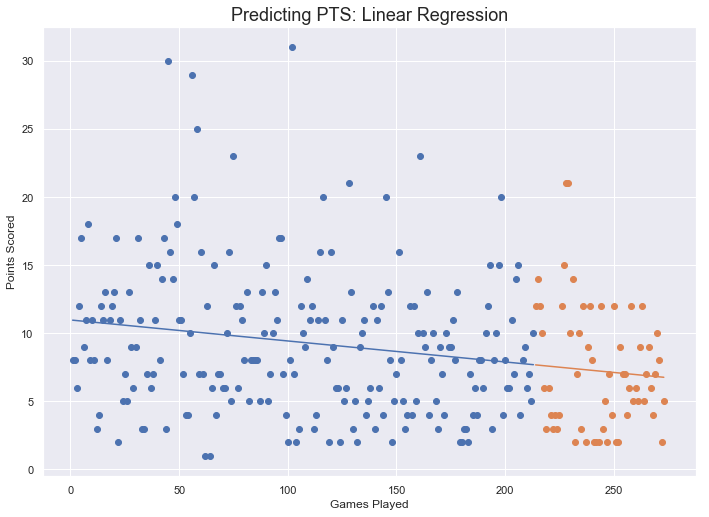

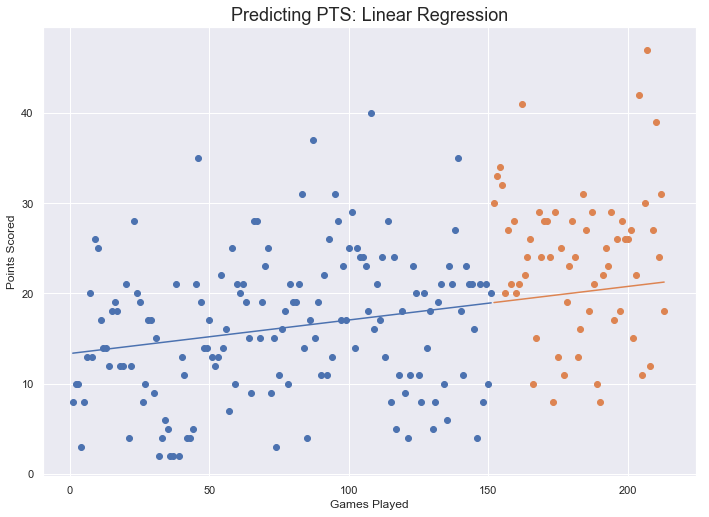

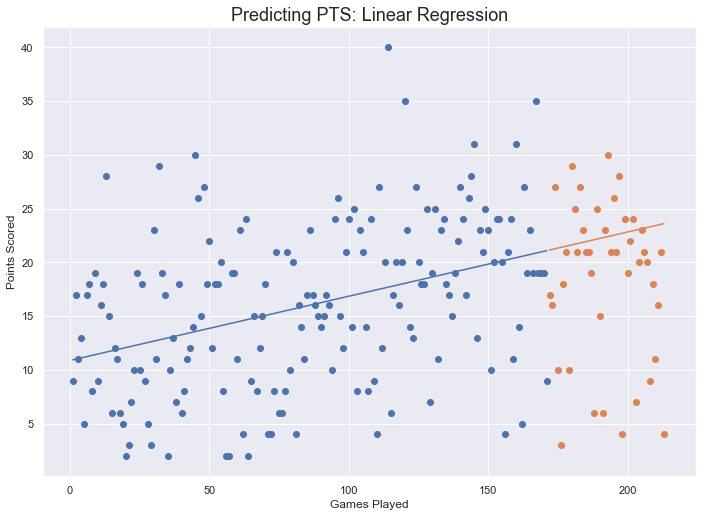

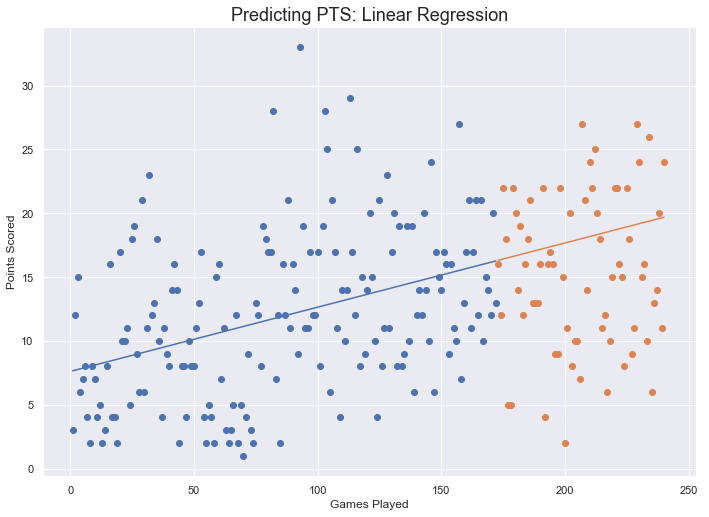

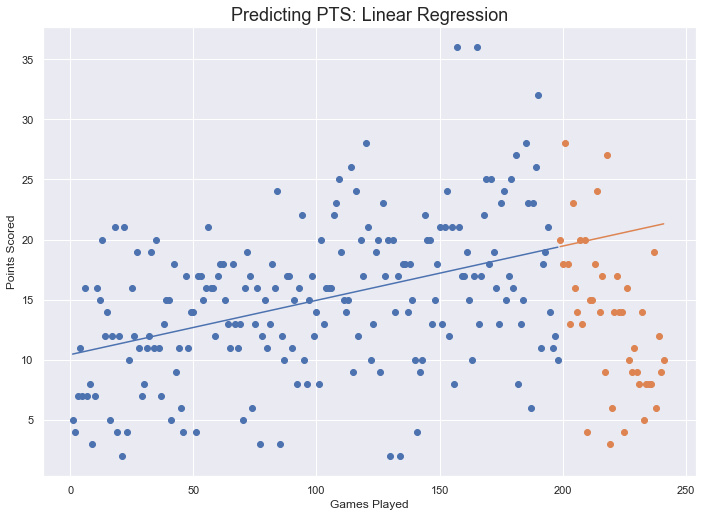

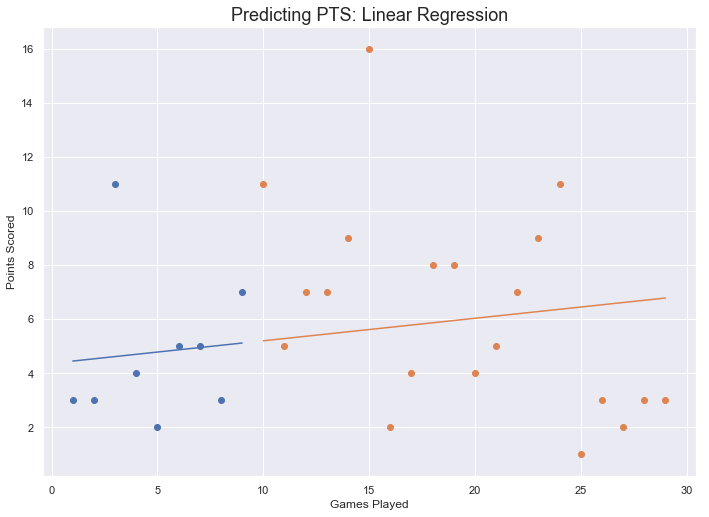

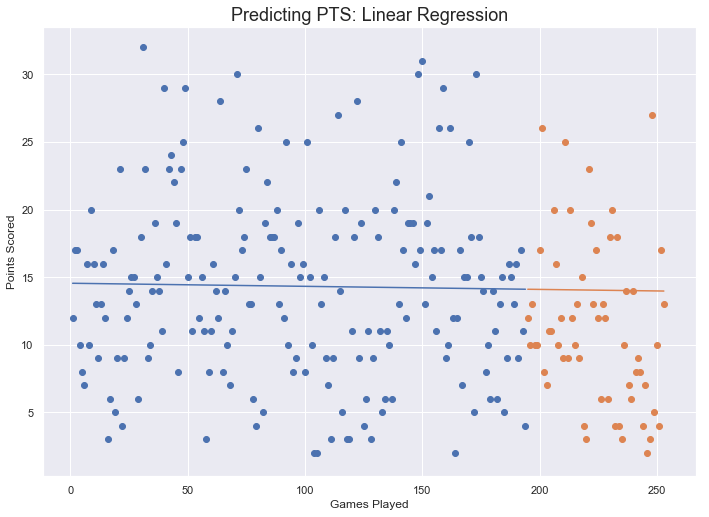

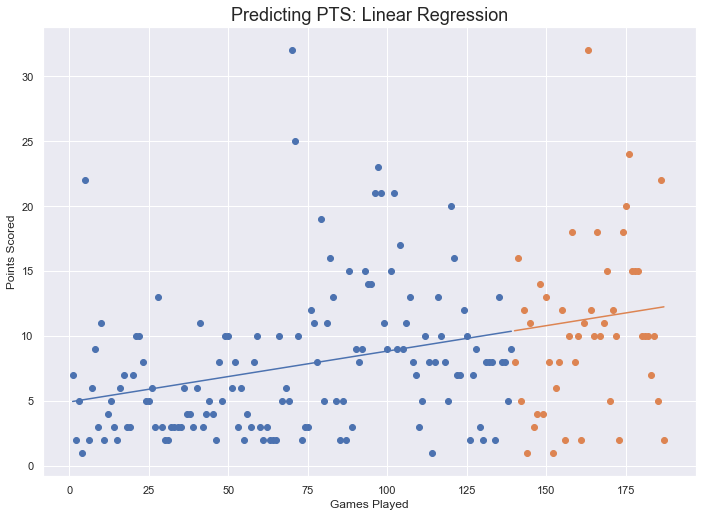

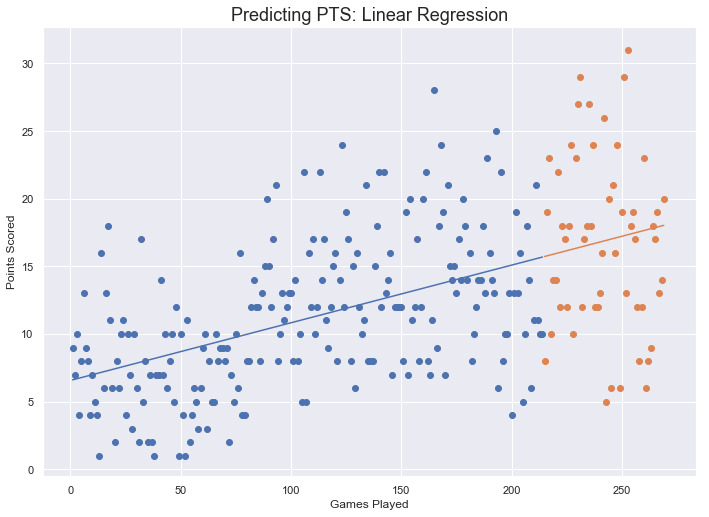

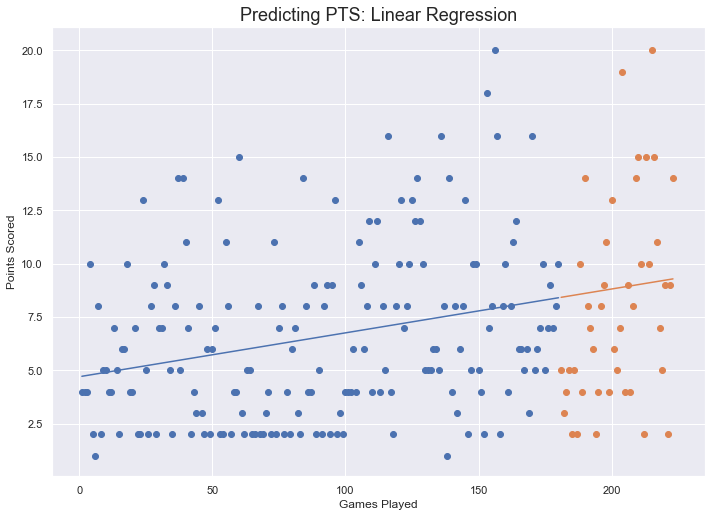

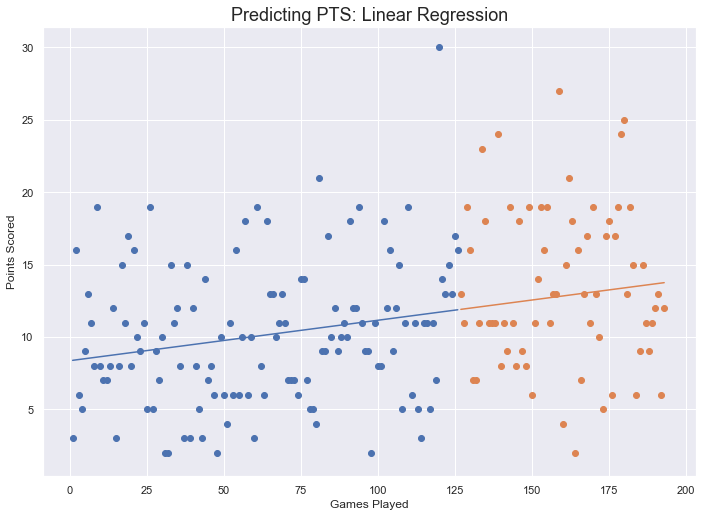

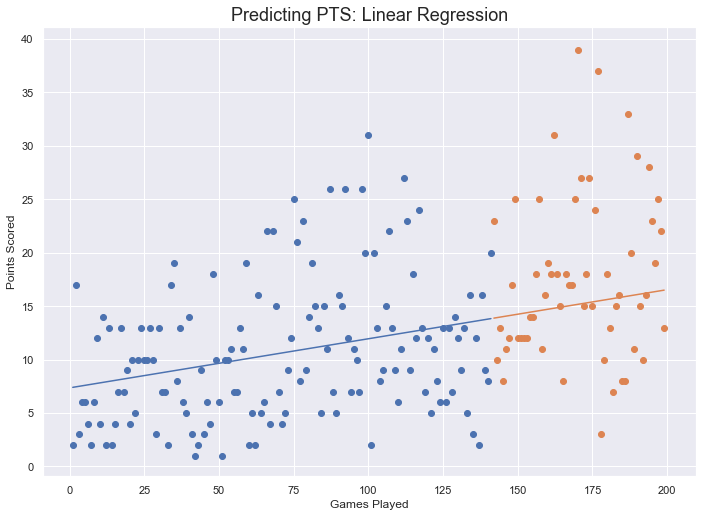

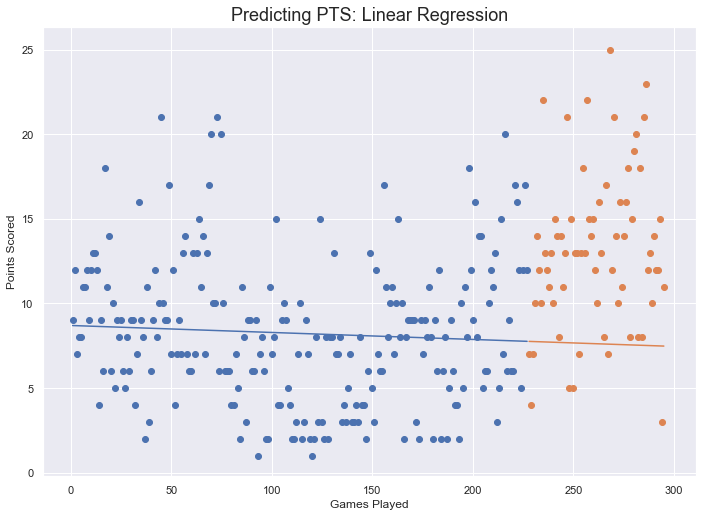

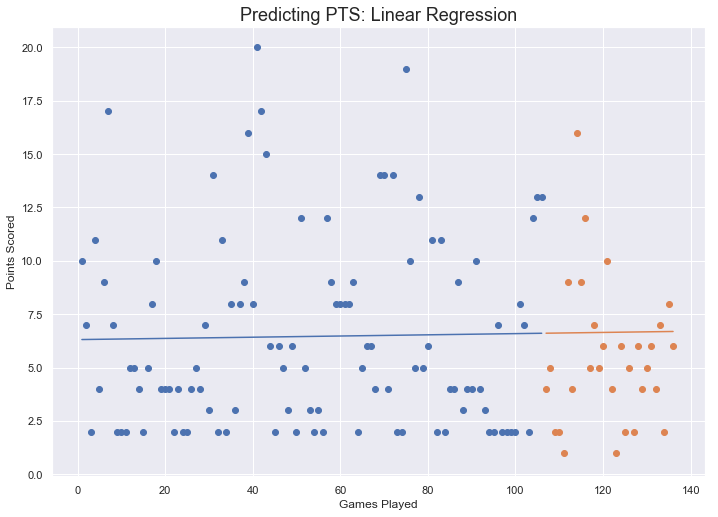

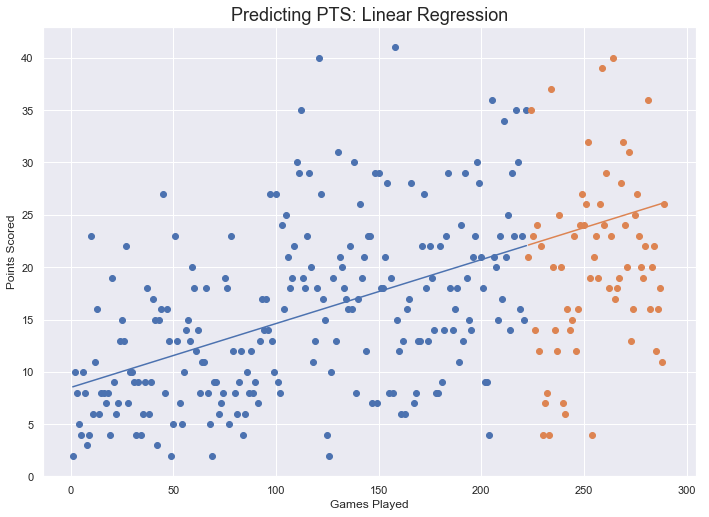

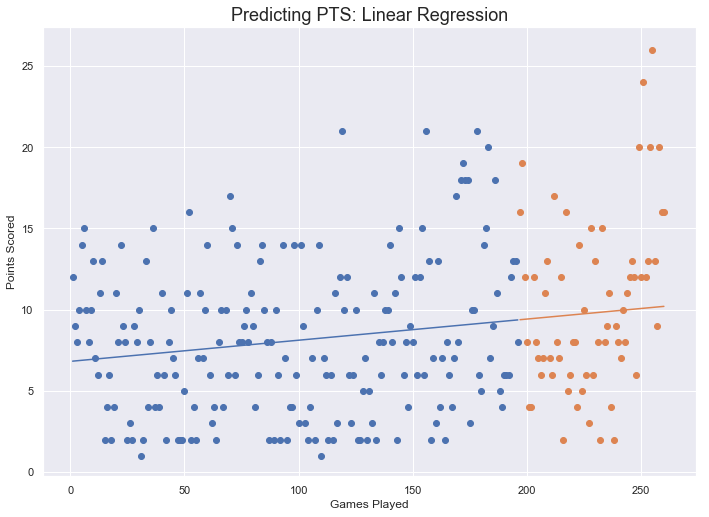

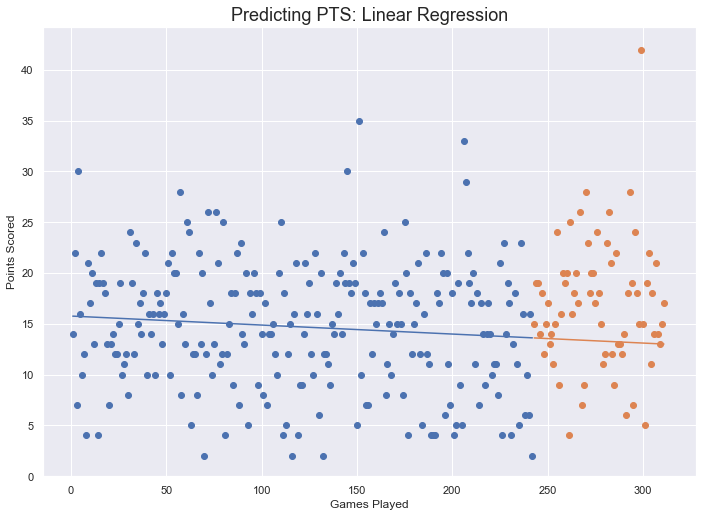

In [25]:
#linear regression
lr = LinearRegression()
apply_model(lr)

player w/wiggian01 average ppg: 13.75
player p/parkeja01 average ppg: 15.057692307692308
player e/embiijo01 average ppg: 22.344827586206897
player g/gordoaa01 average ppg: 18.0
player e/exumda01 average ppg: 7.0
player s/smartma01 average ppg: 9.850746268656716
player r/randlju01 average ppg: 19.246153846153845
player s/stausni01 average ppg: 7.26
player v/vonleno01 average ppg: 6.522388059701493
player p/paytoel01 average ppg: 13.0
player m/mcderdo01 average ppg: 6.583333333333333
player l/lavinza01 average ppg: 17.451612903225808
player w/warretj01 average ppg: 20.761904761904763
player n/nurkiju01 average ppg: 15.779411764705882
player h/harriga01 average ppg: 18.0
player c/cabocbr01 average ppg: 5.0
player h/hoodro01 average ppg: 12.152542372881356
player n/napiesh01 average ppg: 10.0
player c/capelca01 average ppg: 13.981818181818182
player a/anderky01 average ppg: 8.0


/Users/Sachin/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/Sachin/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


player h/harrijo01 average ppg: 11.925373134328359
player d/dinwisp01 average ppg: 13.0


/Users/Sachin/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/Sachin/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


player g/grantje01 average ppg: 9.852941176470589
player r/robingl02 average ppg: 6.0


/Users/Sachin/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


player j/jokicni01 average ppg: 20.91044776119403
player p/poweldw01 average ppg: 10.34375


/Users/Sachin/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/Sachin/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


player c/clarkjo01 average ppg: 11.72463768115942
6.2662845905338775


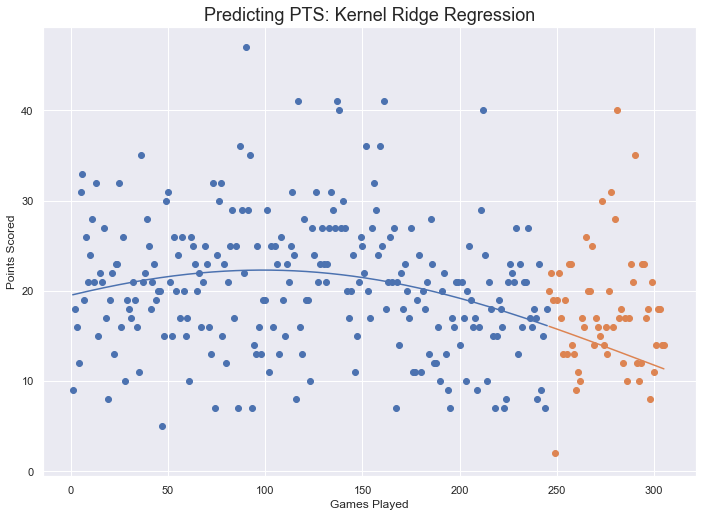

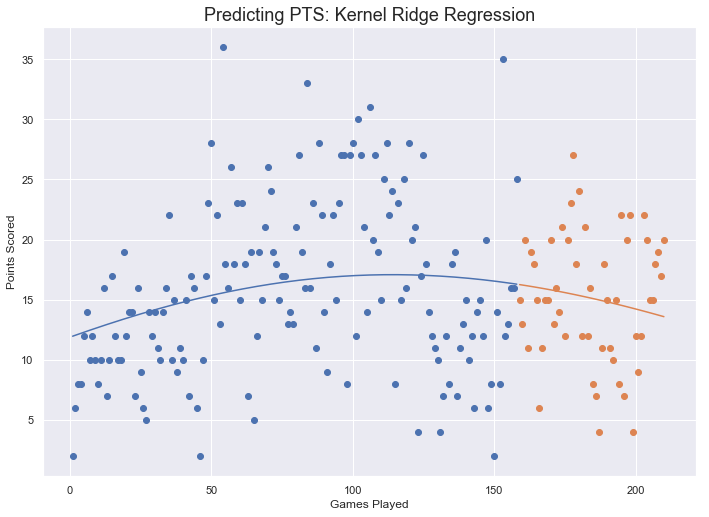

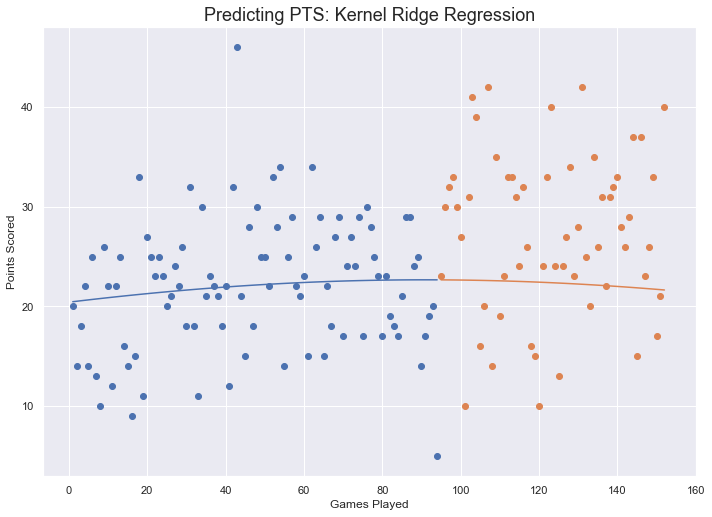

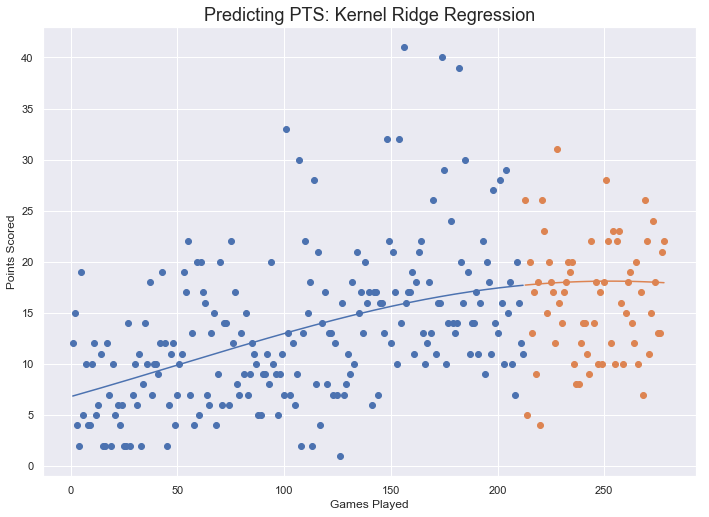

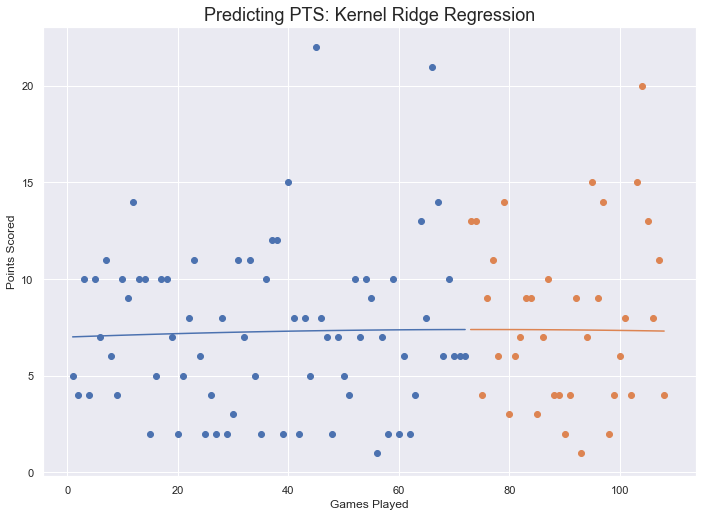

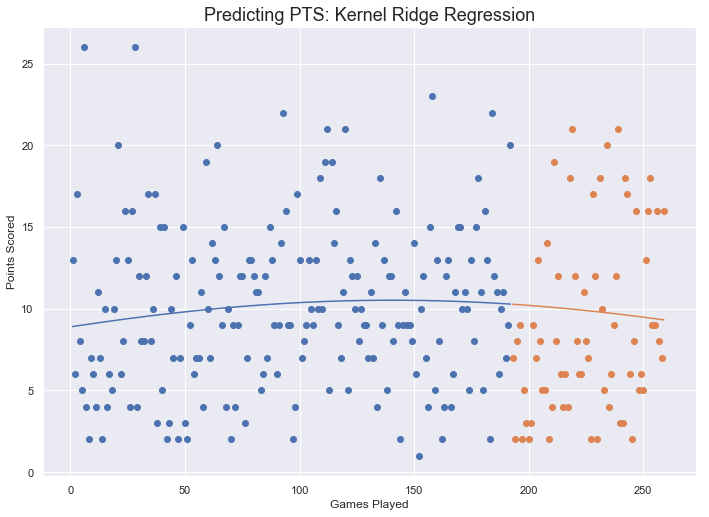

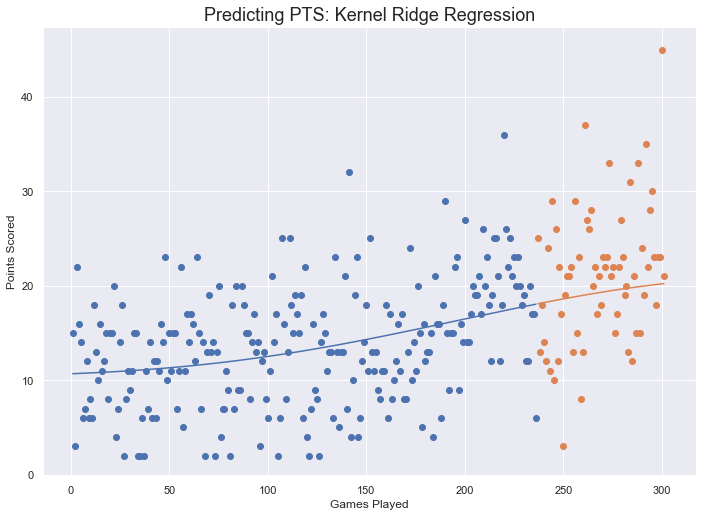

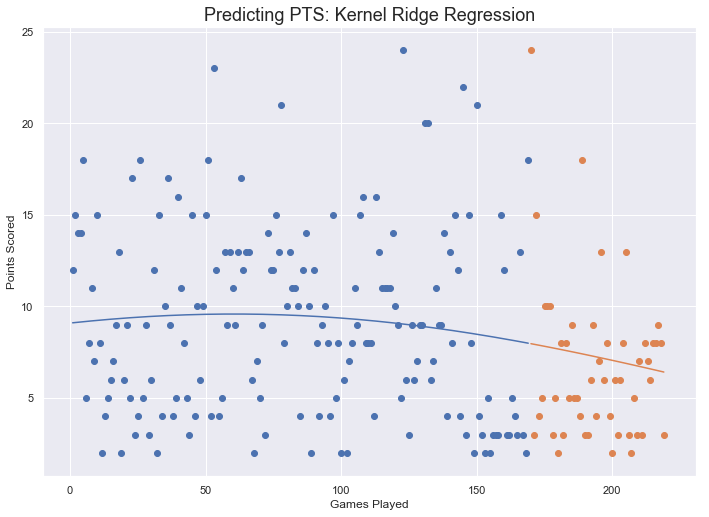

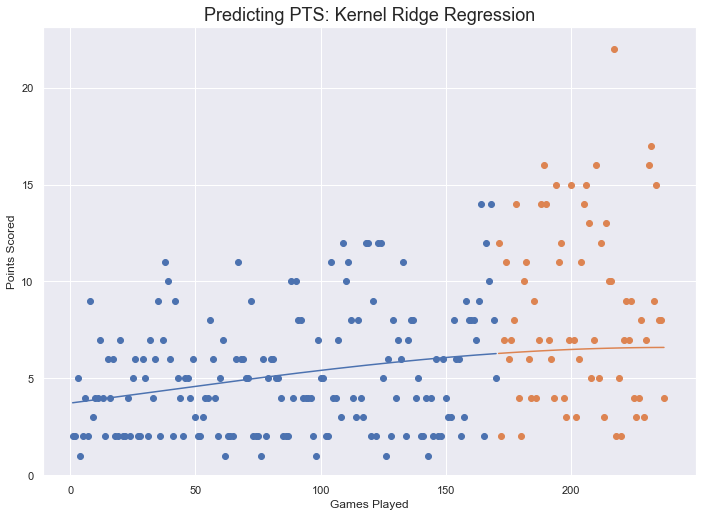

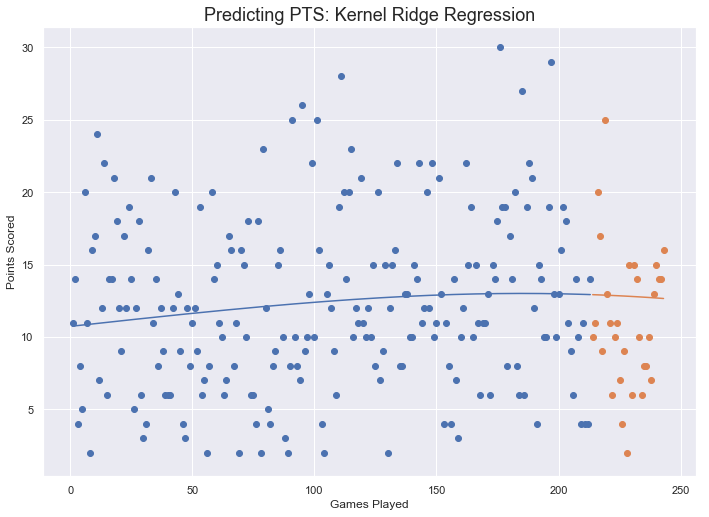

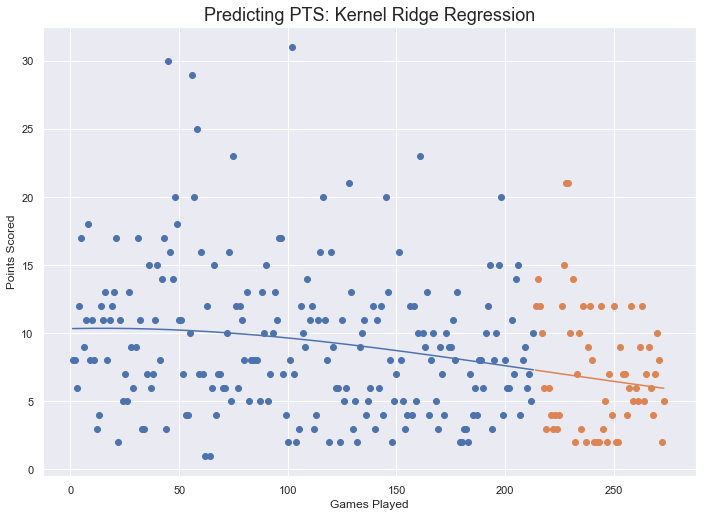

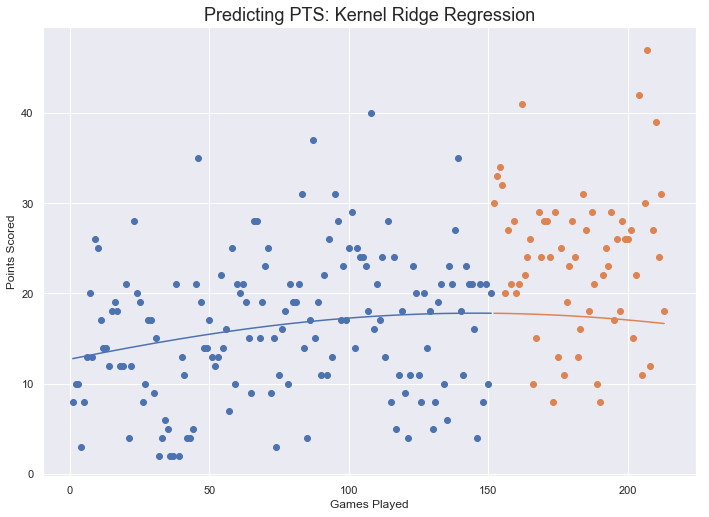

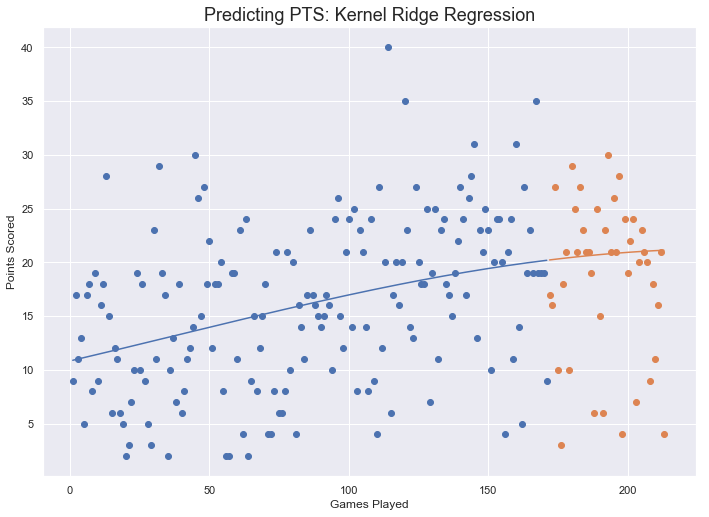

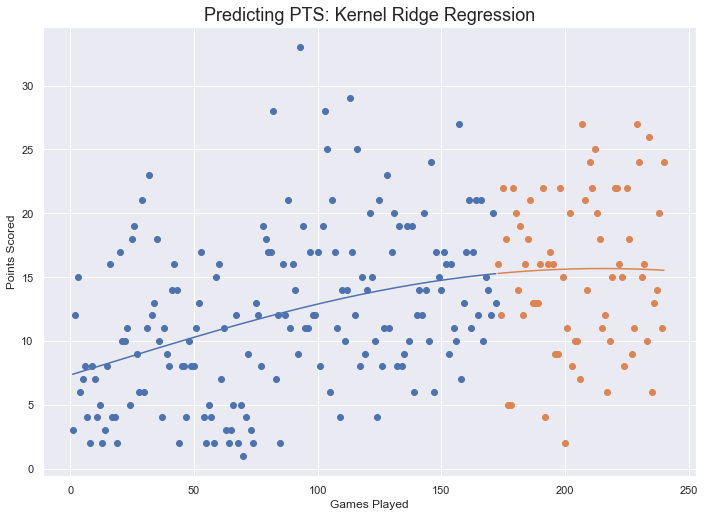

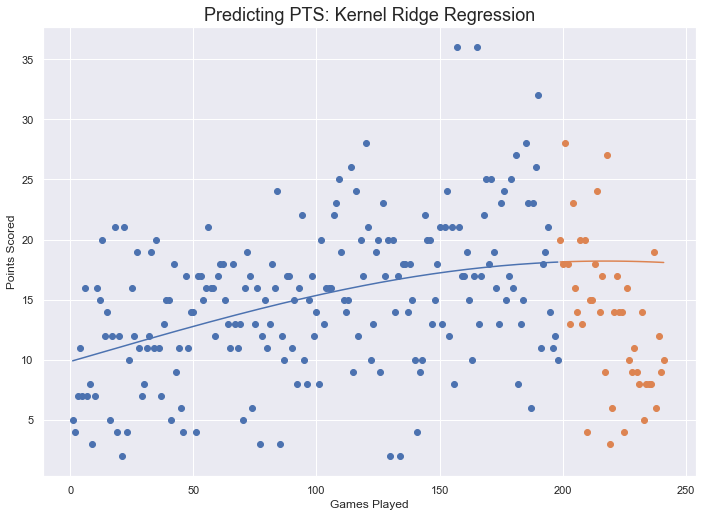

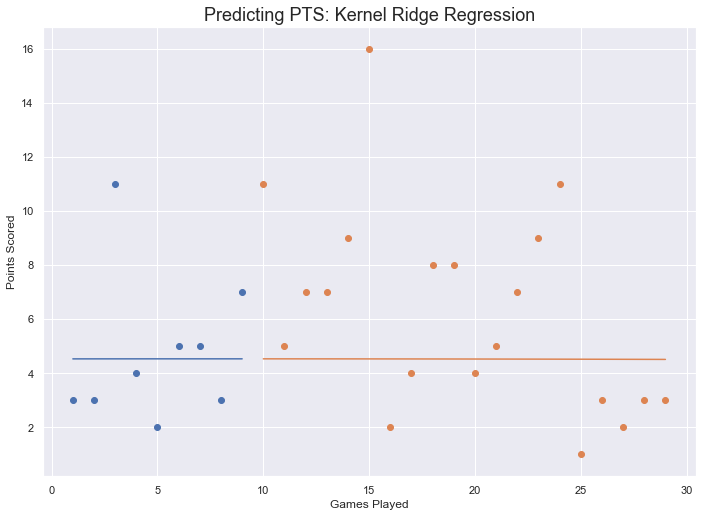

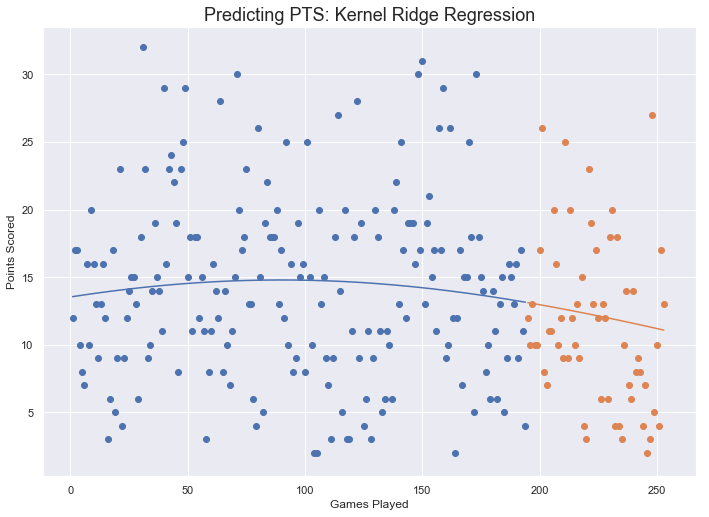

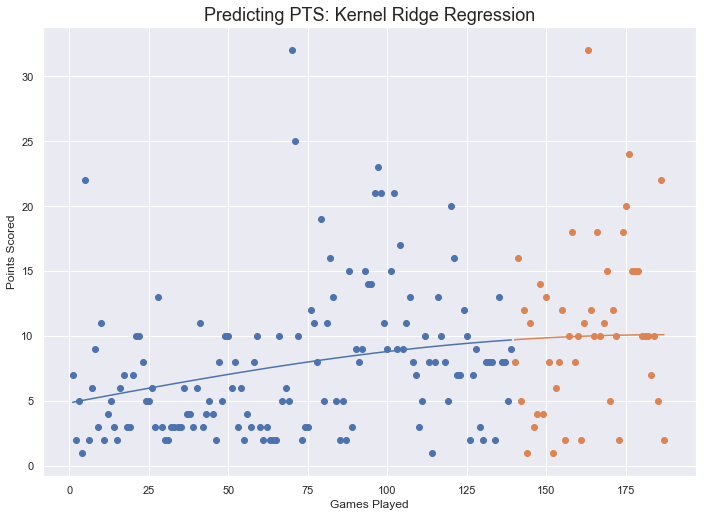

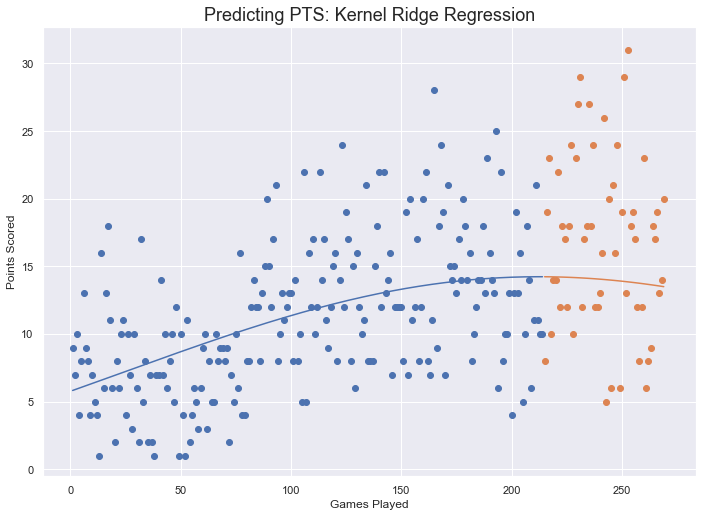

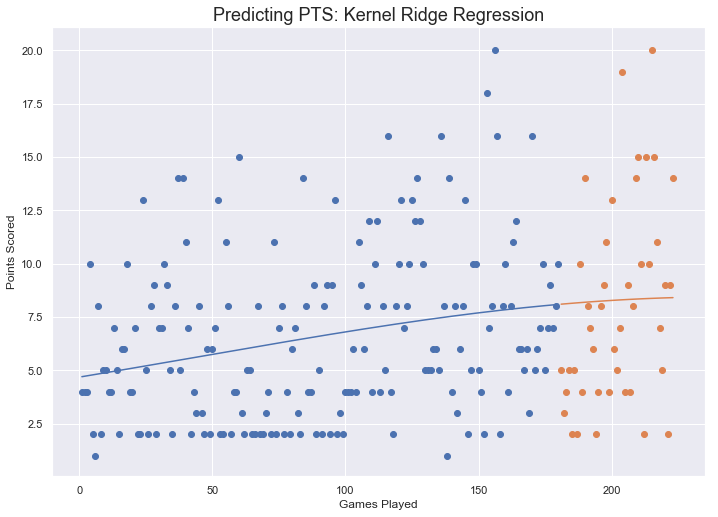

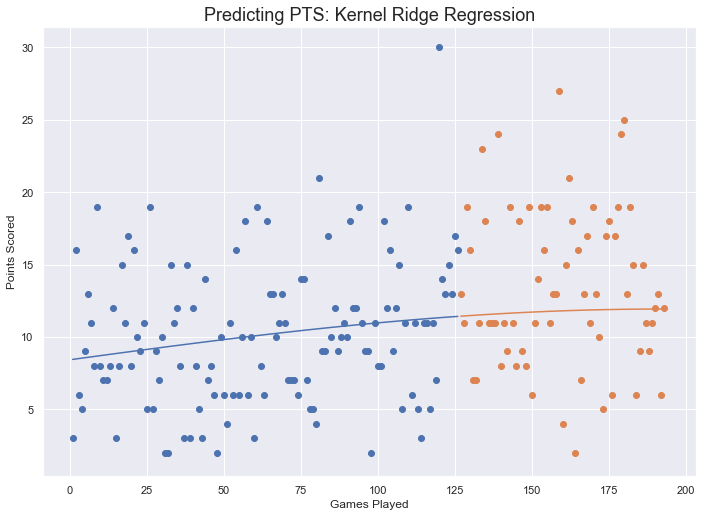

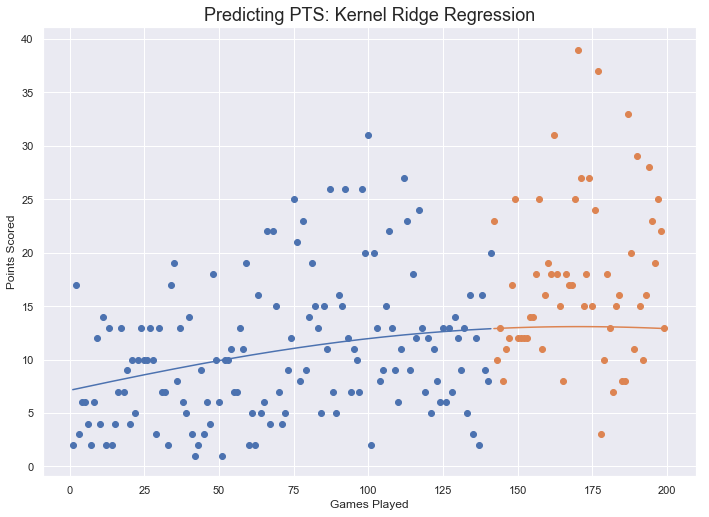

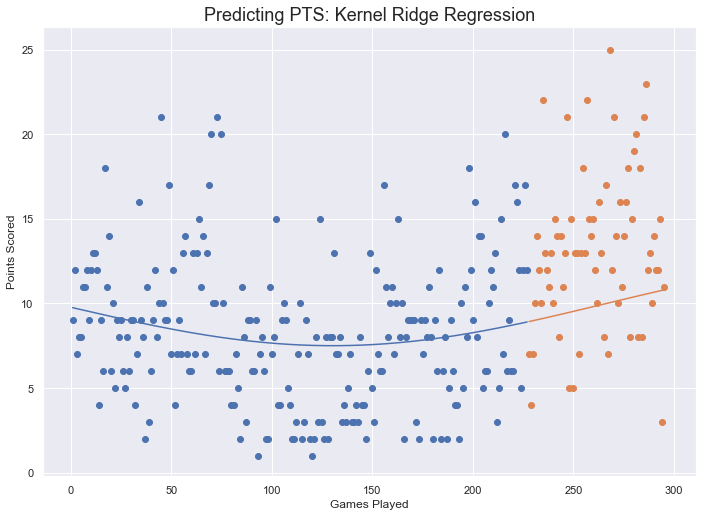

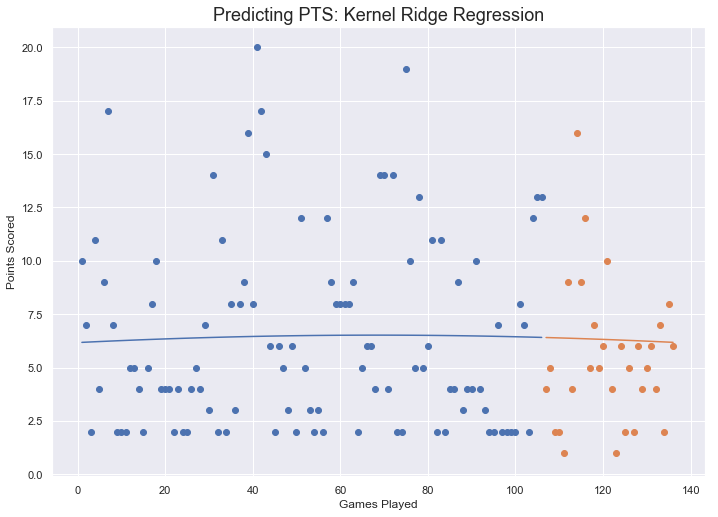

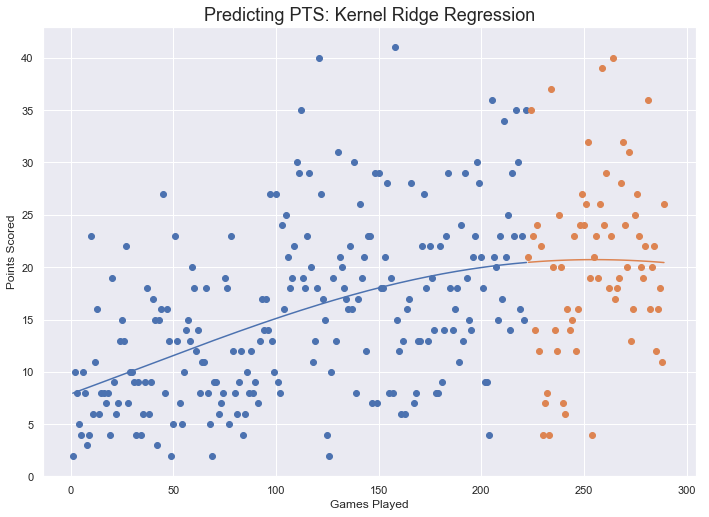

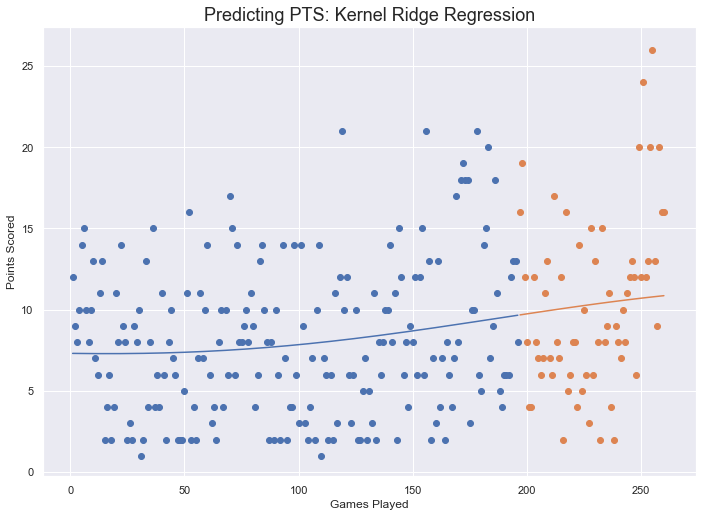

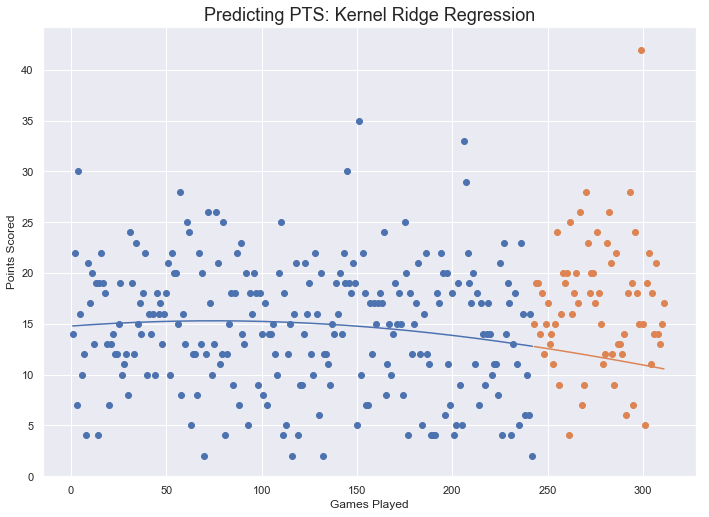

In [26]:
#kernel ridge regression
krr = KernelRidge(alpha=0.5, kernel='rbf', gamma=0.00001, degree=3, coef0=1, kernel_params=None)
apply_model(krr)

Classifier: player w/wiggian01 rmse error is: 6.671630578259986
Classifier: player p/parkeja01 rmse error is: 7.126829057352294
Classifier: player e/embiijo01 rmse error is: 8.167136046934697
Classifier: player g/gordoaa01 rmse error is: 9.052390828355476
Classifier: player e/exumda01 rmse error is: 4.488345866856105
Classifier: player s/smartma01 rmse error is: 5.555813062407036
Classifier: player r/randlju01 rmse error is: 7.3294013329310195
Classifier: player s/stausni01 rmse error is: 4.225153654192536
Classifier: player v/vonleno01 rmse error is: 4.581275866905194
Classifier: player p/paytoel01 rmse error is: 6.651582681475903
Classifier: player m/mcderdo01 rmse error is: 4.659161690210516
Classifier: player l/lavinza01 rmse error is: 8.773041543087773
Classifier: player w/warretj01 rmse error is: 10.144887444437003
Classifier: player n/nurkiju01 rmse error is: 6.853494911238099
Classifier: player h/harriga01 rmse error is: 12.125619278426715
Classifier: player c/cabocbr01 rmse er

/Users/Sachin/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/Sachin/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Classifier: player d/dinwisp01 rmse error is: 7.788428589782117


/Users/Sachin/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/Sachin/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Classifier: player g/grantje01 rmse error is: 6.58861596188109
Classifier: player r/robingl02 rmse error is: 3.3706501207090422


/Users/Sachin/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/Sachin/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Classifier: player j/jokicni01 rmse error is: 8.564080834283232
Classifier: player p/poweldw01 rmse error is: 5.345707254941677


/Users/Sachin/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Classifier: player c/clarkjo01 rmse error is: 6.190323683067975
6.829591336555382


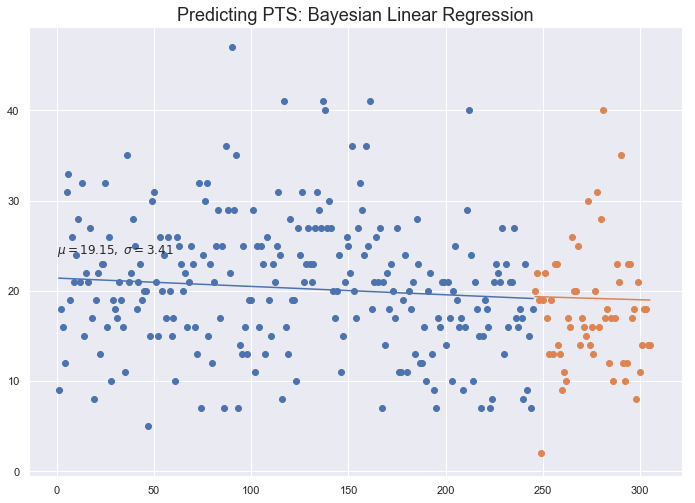

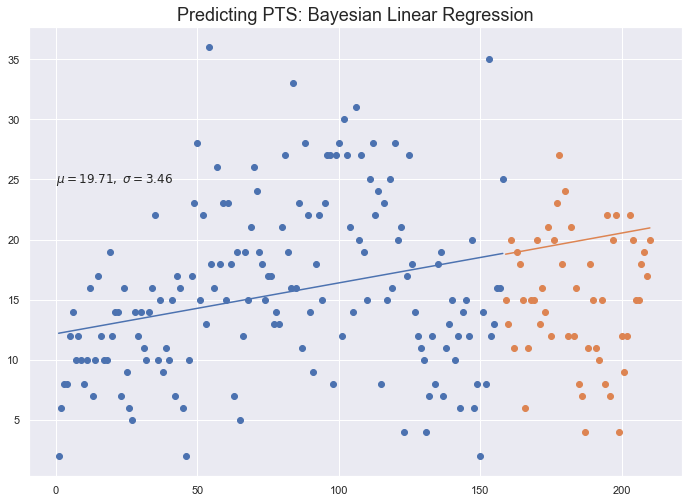

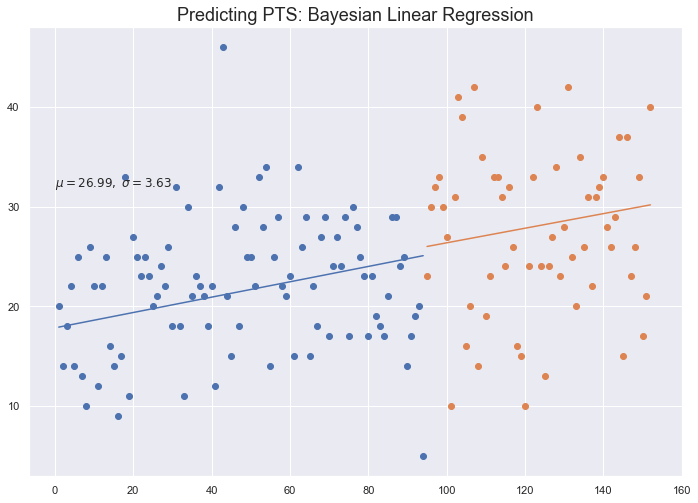

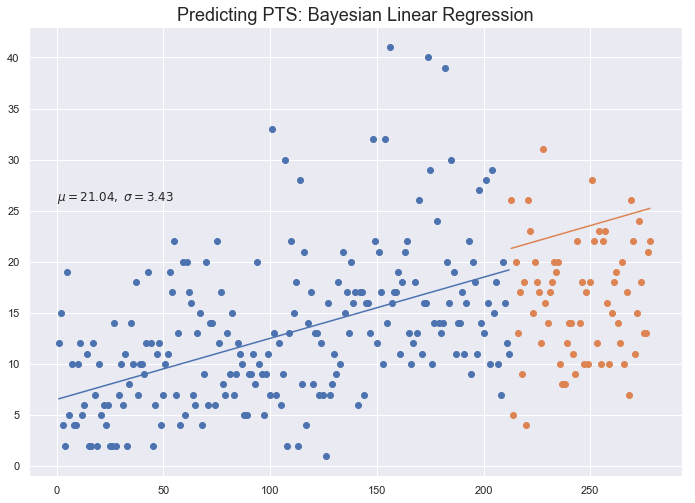

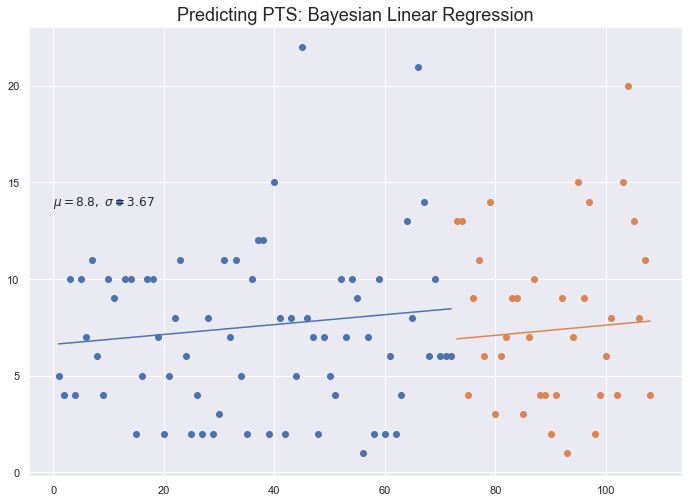

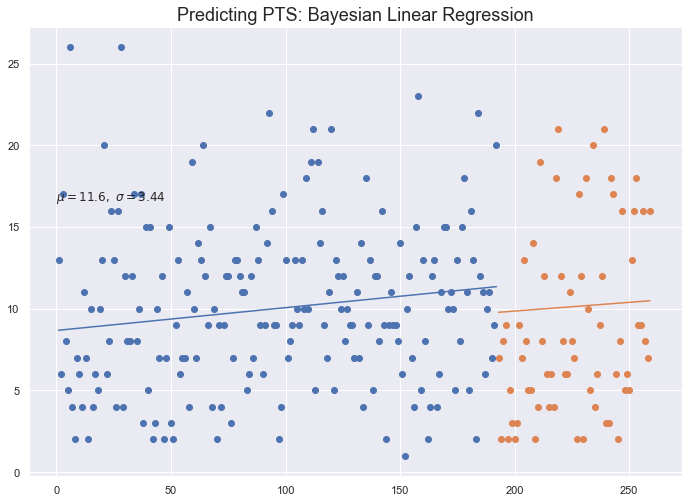

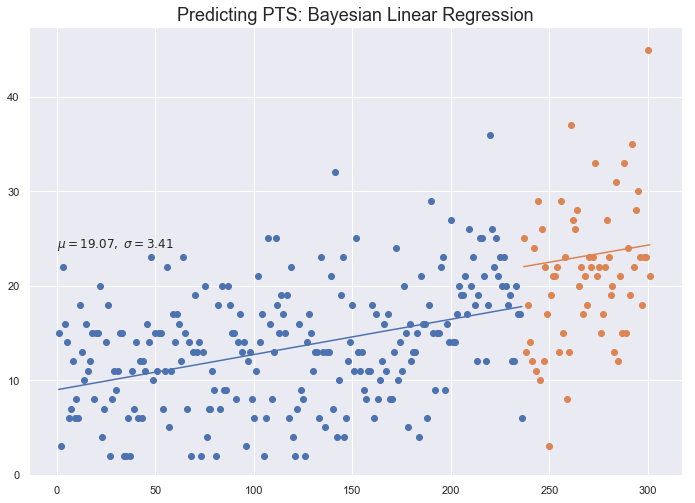

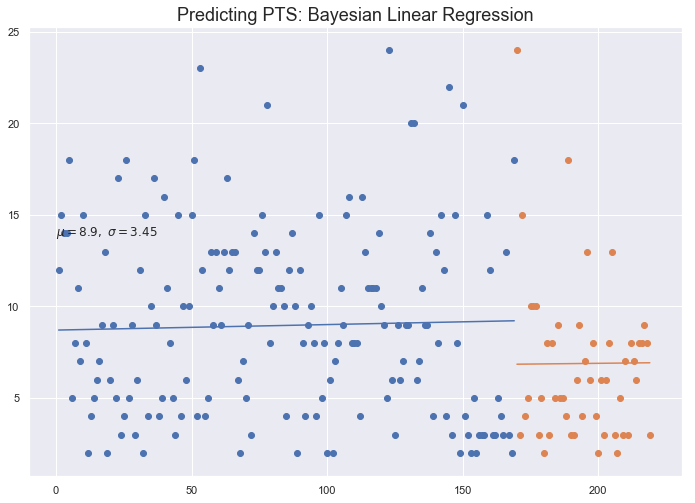

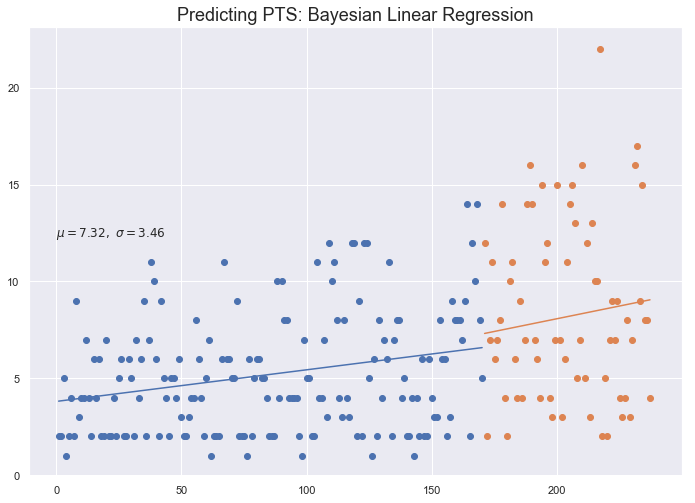

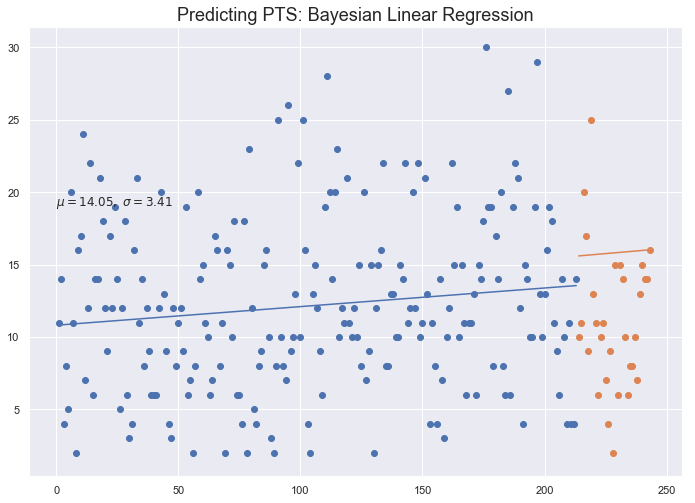

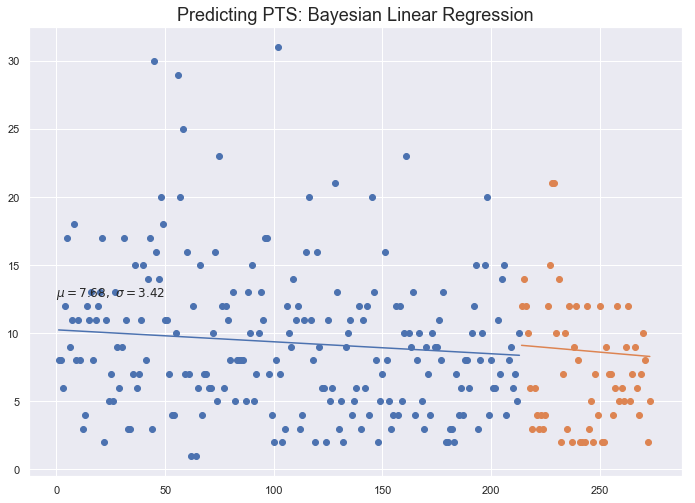

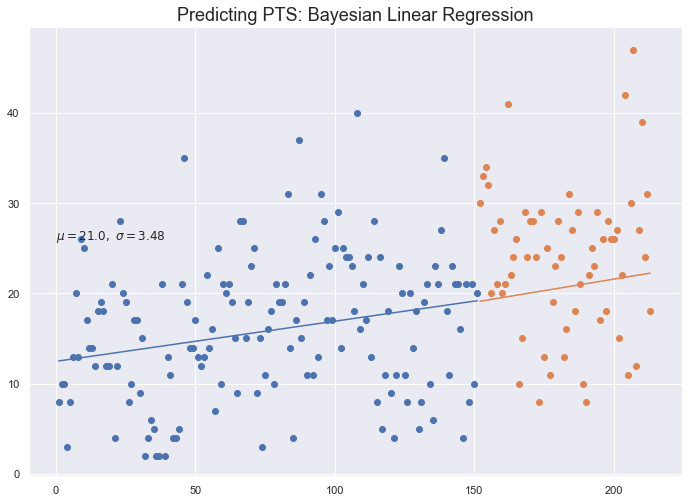

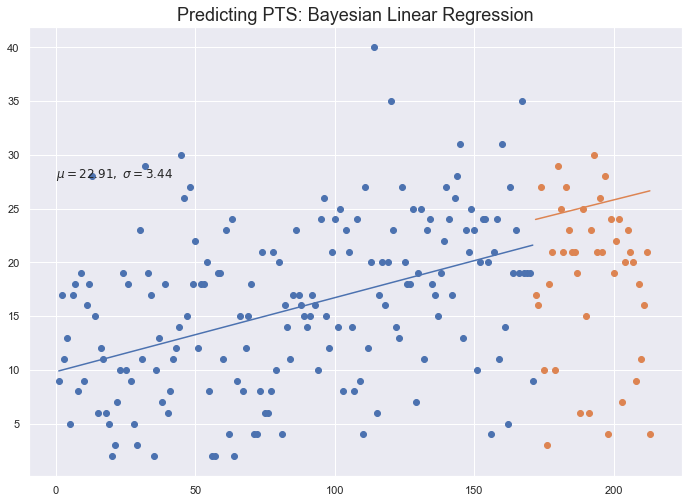

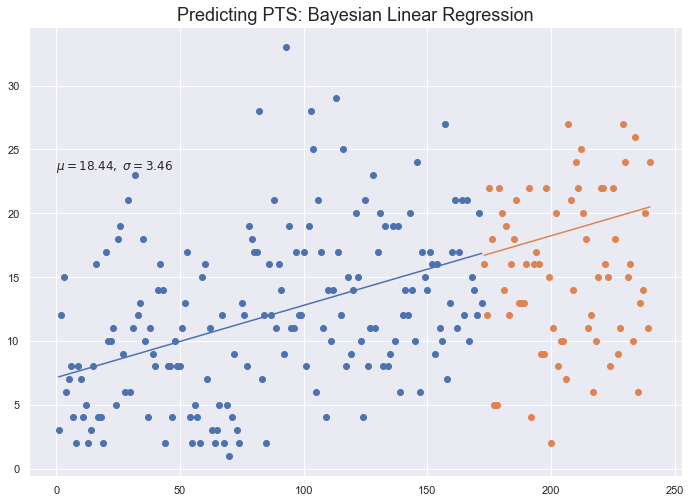

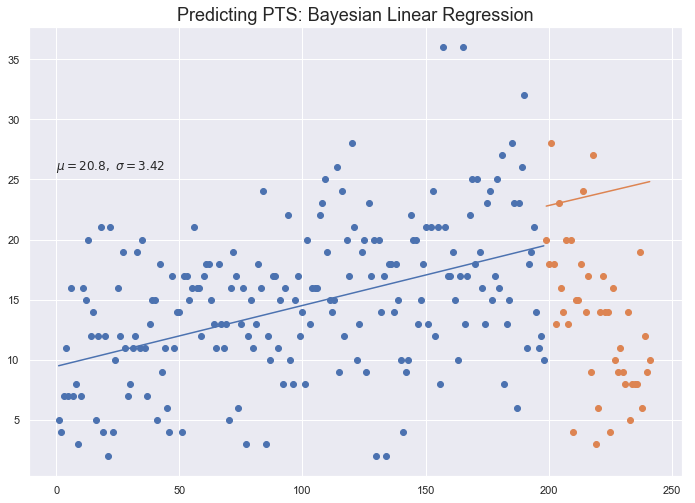

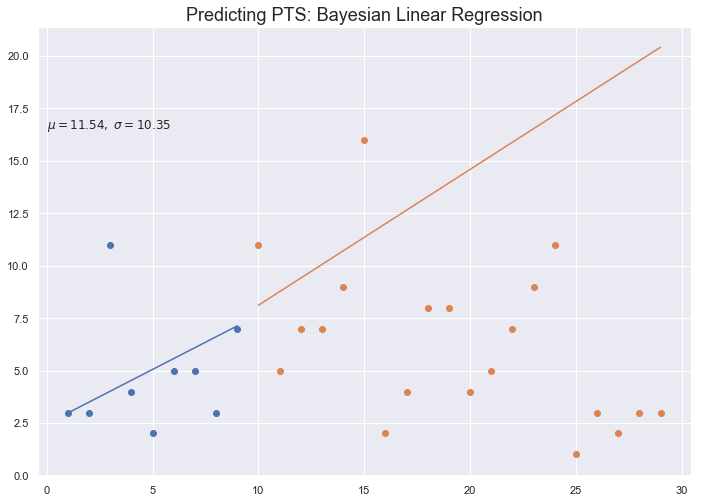

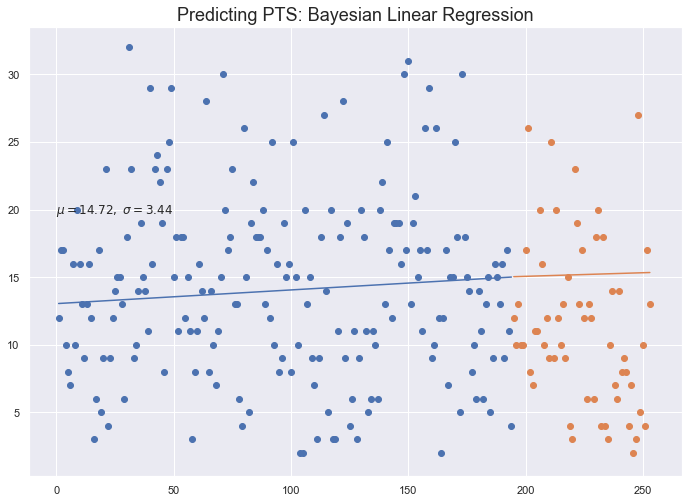

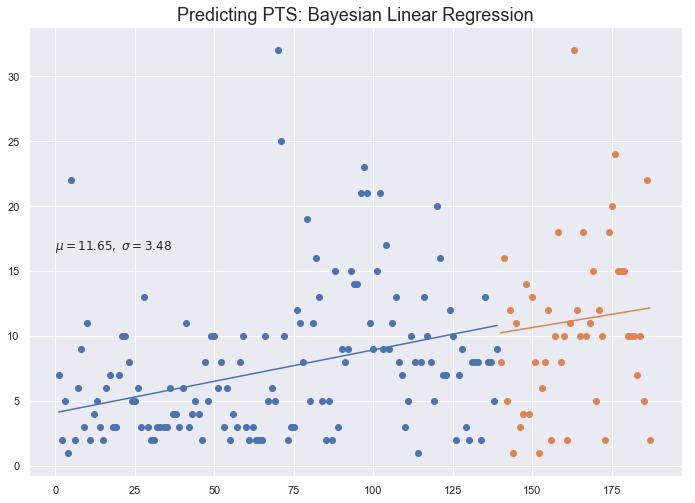

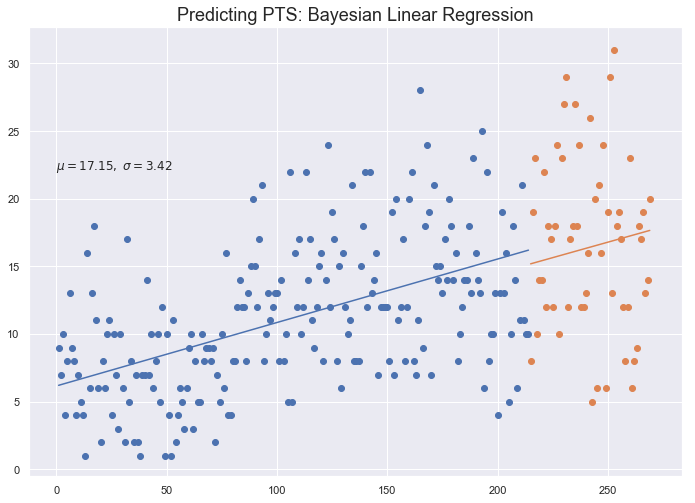

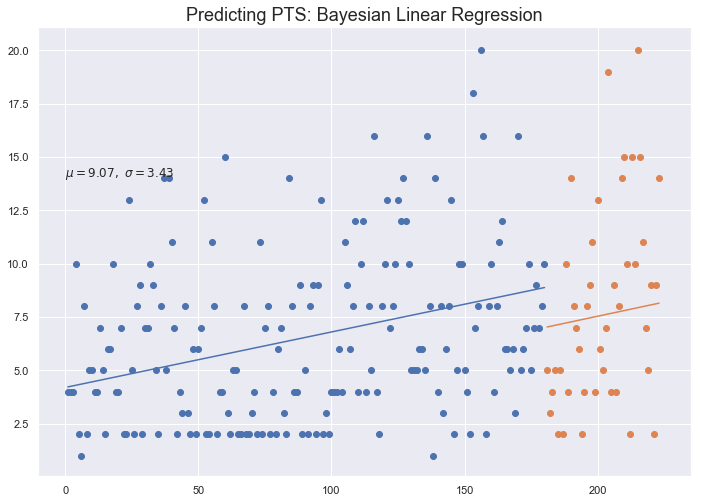

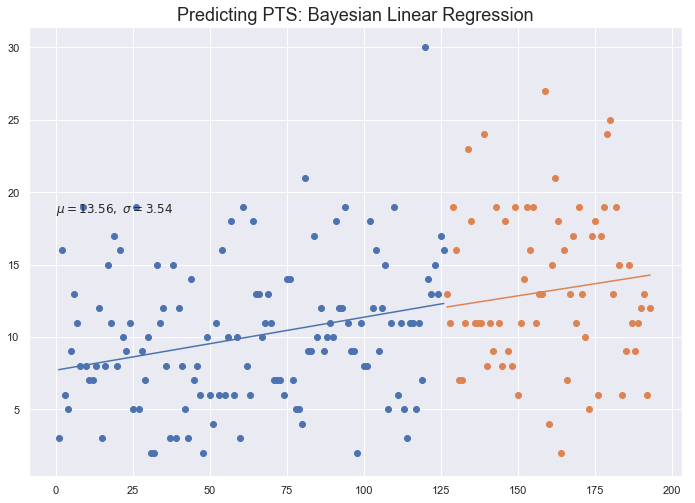

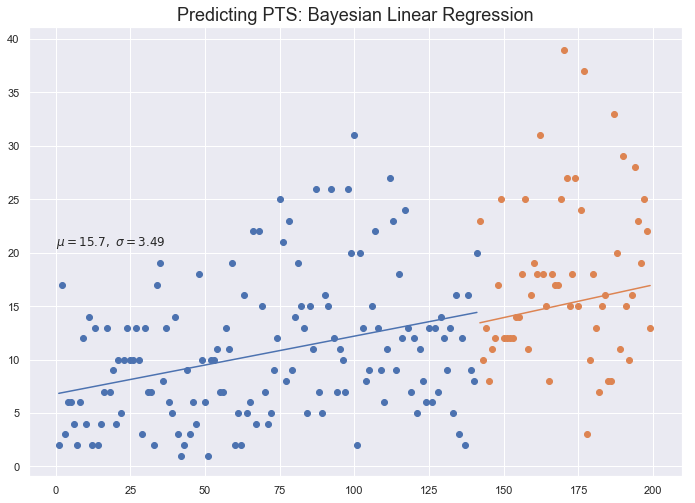

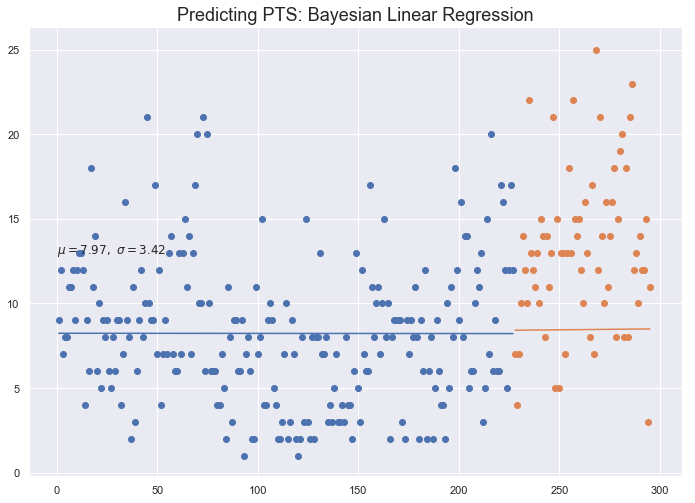

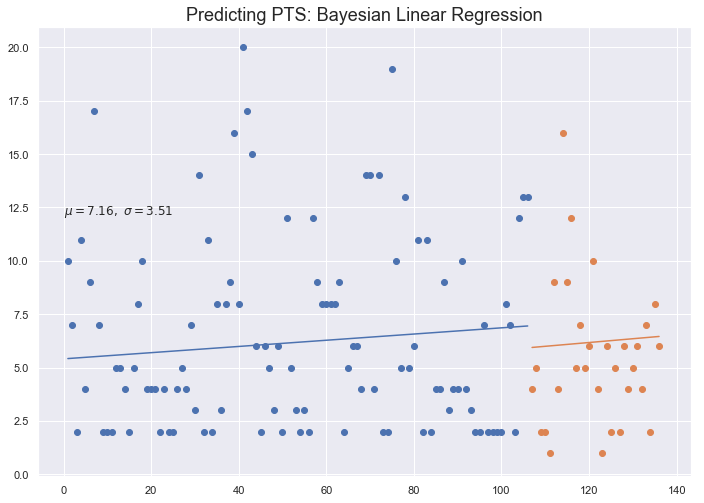

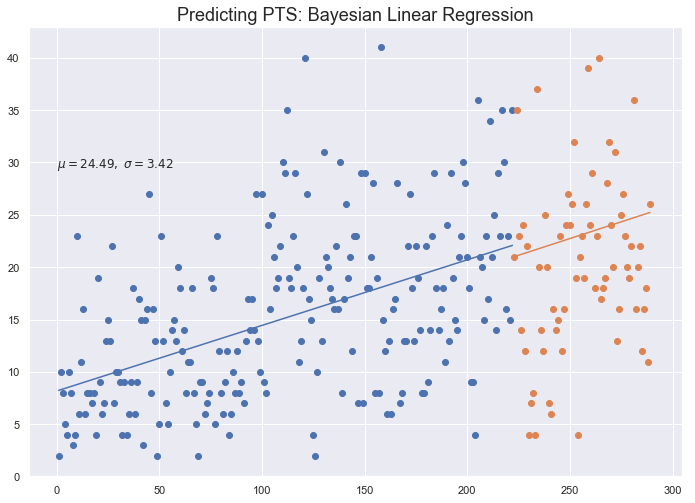

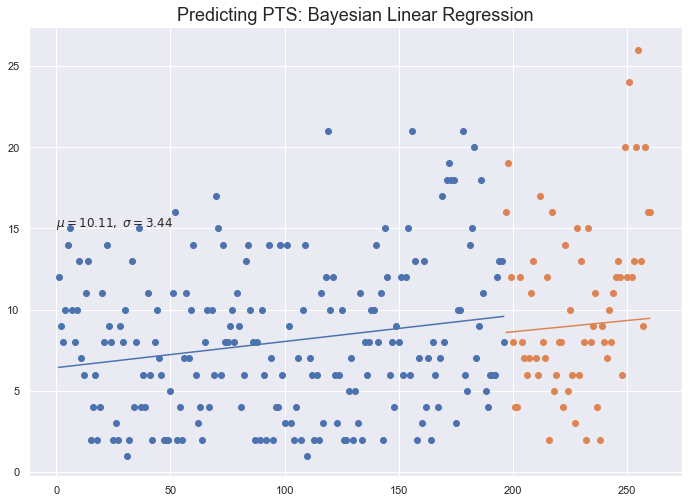

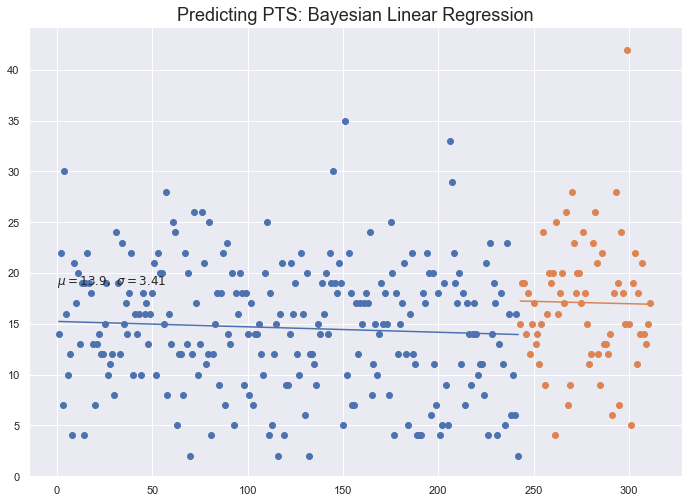

In [12]:
# bayesian linear regression - games played (x) vs pts scored (y)
# currently for one player, calucualte for all players!

def posterior(n_samples):
    x_1 = np.ones((n_samples,2))
    y_1 = np.ones(n_samples)
    for i in range(0,n_samples):
        x_1[i,0] = x[i]
        y_1[i] = y[i]
        
    s_0 = K
    beta = 0.3
    m_0 = mu
    
    s_n = inv(inv(s_0) + beta * (np.matmul(x_1.T,x_1)))
    m_n = np.matmul(s_n,((np.matmul(inv(s_0), m_0)) + (beta * (np.matmul(x_1.T,y_1)))))
    return (m_n, s_n)

def sample_n_points(m_n,s_n, n):
    
    lines = []
    sample = np.random.multivariate_normal(m_n,s_n,n)    
    for i in range (0,n):
        lines.append(sample[i][0]*x + sample[i][1])
        plt.plot(x,lines[i])

j = 0
rmse_avg = []
for i in range(len(playerDF)):
    plt.figure(i)
    jokic = playerDF[i]
    jokic = jokic.apply(pd.to_numeric,errors='coerce')
    jokic = jokic[jokic.PTS != 0]
    jokic = np.array(jokic.PTS)
    y = jokic.reshape(-1,1)

    games = np.arange(1,len(jokic) + 1)
    x = games.reshape(-1,1)
    mu = [0,0]
    K = 1 * np.eye(2)
    w_prior = multivariate_normal(mu,K)

    m_n, s_n = posterior(len(jokic))
    

    #calculating predictions!
    jokic2019 = player2019DF[i]
    jokic2019 = jokic2019.apply(pd.to_numeric,errors='coerce')
    jokic2019 = jokic2019[jokic2019.PTS != 0]
    jokic2019 = np.array(jokic2019.PTS)
    y_hat = jokic2019.reshape(-1,1)
    beta = 0.3
    gamesPl_tst = len(jokic2019) + 1
    games_hat = np.arange(len(games)+1, len(games) + gamesPl_tst)

    x_hat = games_hat.reshape(-1,1)
    x1_hat = np.ones((len(x_hat),2))
    for i in range(len(x_hat)):
        x1_hat[i,0] = x_hat[i]

    muPred = np.dot(m_n,x1_hat.T)
    sigmaPred = (1/beta) + np.dot(x1_hat,np.dot(s_n,x1_hat.T))
    

    sample = np.random.multivariate_normal(muPred, sigmaPred, 1)
    rmse = sqrt(mean_squared_error(sample.flatten(), jokic2019))
    rmse_avg.append(rmse)
    print("Classifier: player {0} rmse error is: {1}".format(players[j],rmse))
    mu_hat, sigma_hat = round(np.mean(muPred),2),round(np.mean(sigmaPred),2)


    plt.scatter(games,jokic)
    plt.scatter(games_hat,jokic2019)
    sample_n_points(m_n,s_n,1)
    plt.plot(games_hat,sample[0])
    plt.text(0, mu_hat + 5, r'$\mu={0},\ \sigma={1}$'.format(mu_hat,sigma_hat))
    plt.title("Predicting PTS: Bayesian Linear Regression", fontsize=18)
    plt.savefig('players_blr/player{}'.format(j))
    j = j + 1

print(np.mean(rmse_avg))
    

player w/wiggian01 average ppg: 20.6530612244898
player p/parkeja01 average ppg: 15.734177215189876
player e/embiijo01 average ppg: 22.04255319148936
player g/gordoaa01 average ppg: 13.018867924528305
player e/exumda01 average ppg: 7.305555555555554
player s/smartma01 average ppg: 10.119791666666664
player r/randlju01 average ppg: 13.63135593220339
player s/stausni01 average ppg: 9.19526627218935
player v/vonleno01 average ppg: 5.141176470588235
player p/paytoel01 average ppg: 12.305164319248828
player m/mcderdo01 average ppg: 9.323943661971832
player l/lavinza01 average ppg: 16.158940397350992
player w/warretj01 average ppg: 16.005847953216374
player n/nurkiju01 average ppg: 11.95930232558139
player h/harriga01 average ppg: 14.914141414141417
player c/cabocbr01 average ppg: 4.777777777777777
player h/hoodro01 average ppg: 14.32474226804124
player n/napiesh01 average ppg: 7.661870503597123
player c/capelca01 average ppg: 11.149532710280372
player a/anderky01 average ppg: 6.561111111111

/Users/Sachin/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/Sachin/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


player h/harrijo01 average ppg: 10.134920634920633
player d/dinwisp01 average ppg: 10.617021276595745


/Users/Sachin/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/Sachin/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


player g/grantje01 average ppg: 8.229074889867844
player r/robingl02 average ppg: 6.462264150943393


/Users/Sachin/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/Sachin/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


player j/jokicni01 average ppg: 15.324324324324325
player p/poweldw01 average ppg: 8.091836734693878


/Users/Sachin/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


player c/clarkjo01 average ppg: 14.685950413223143
6.712422046487202


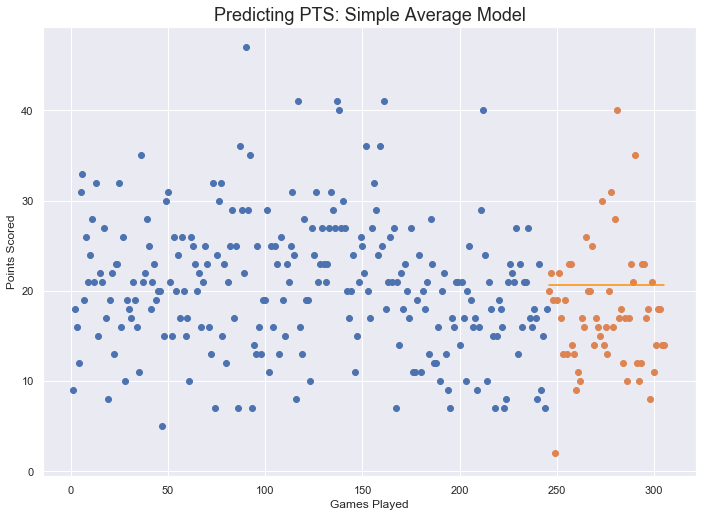

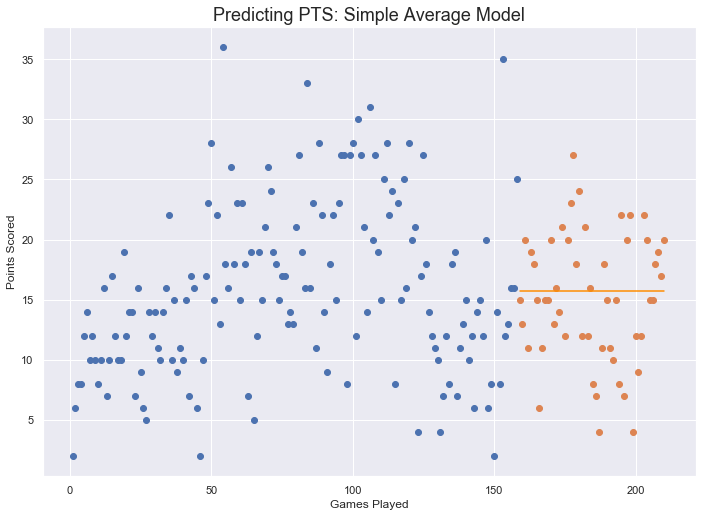

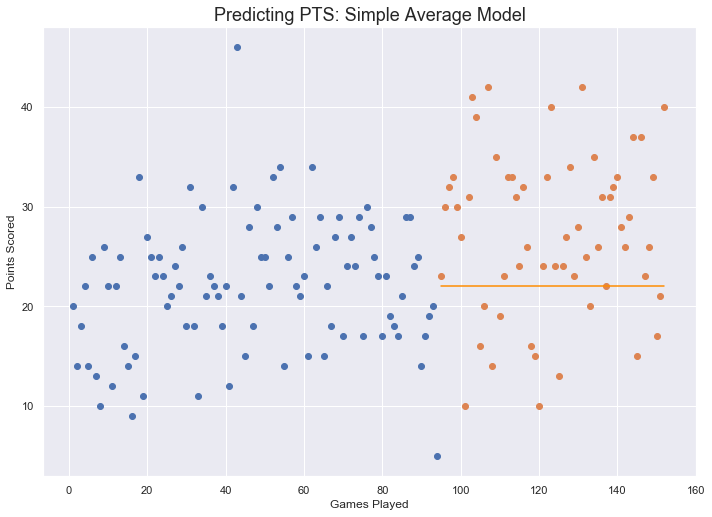

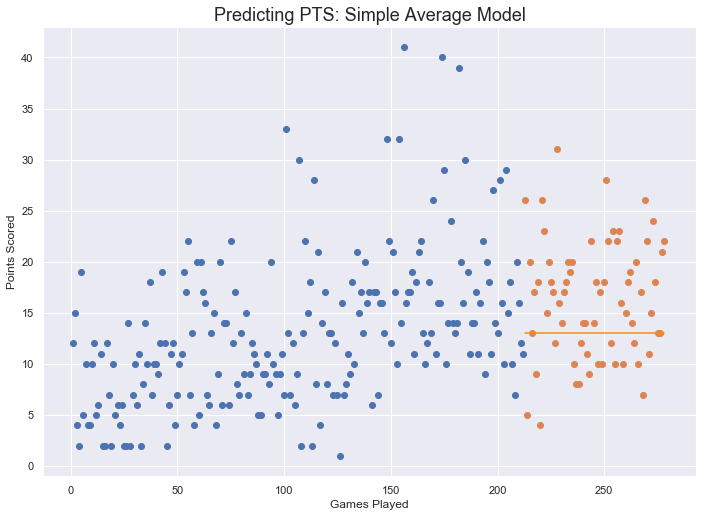

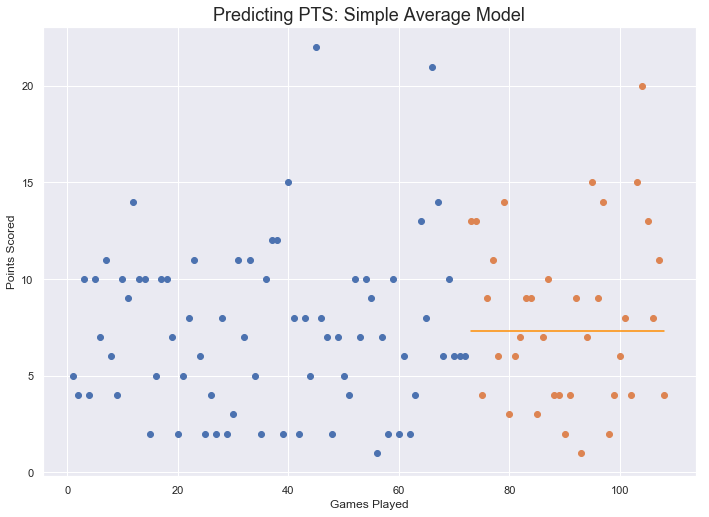

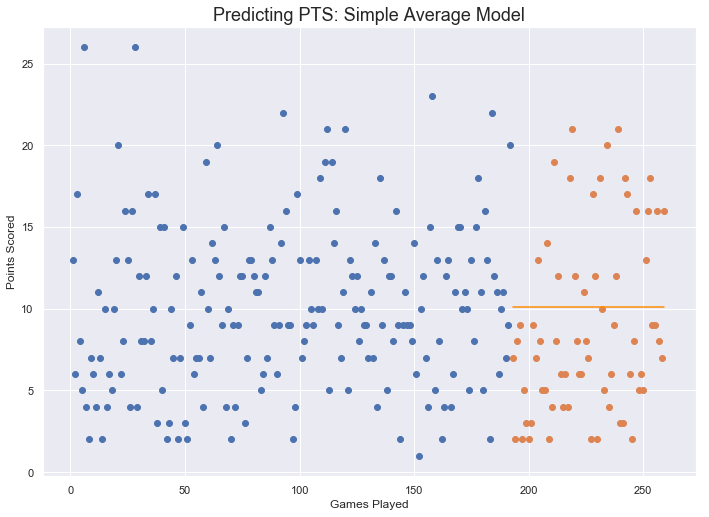

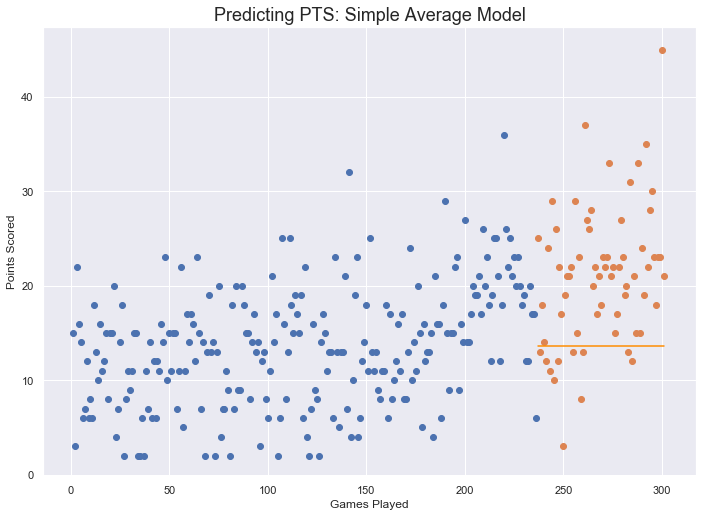

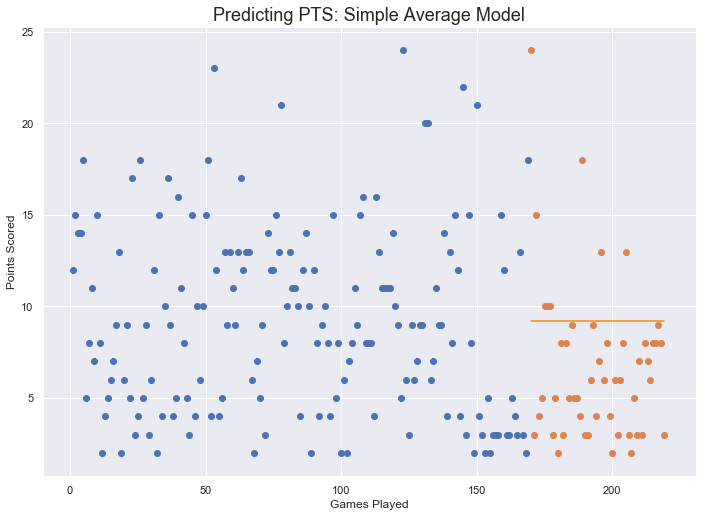

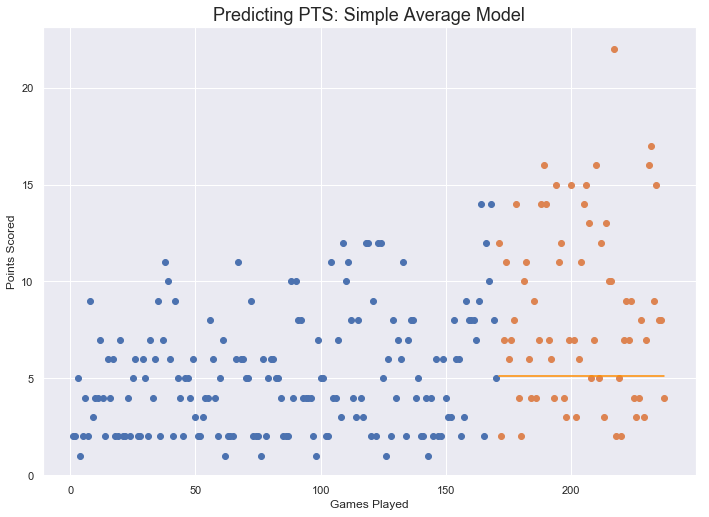

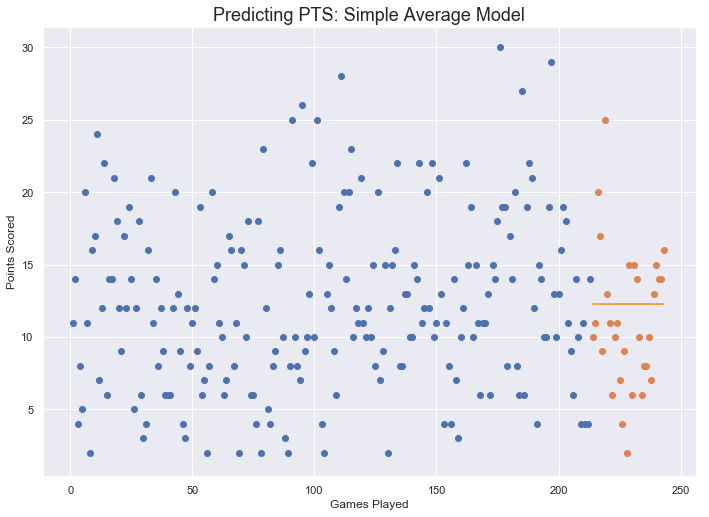

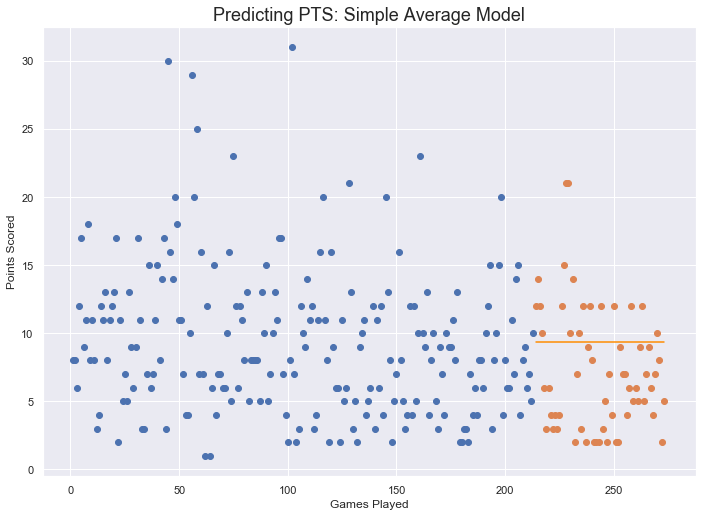

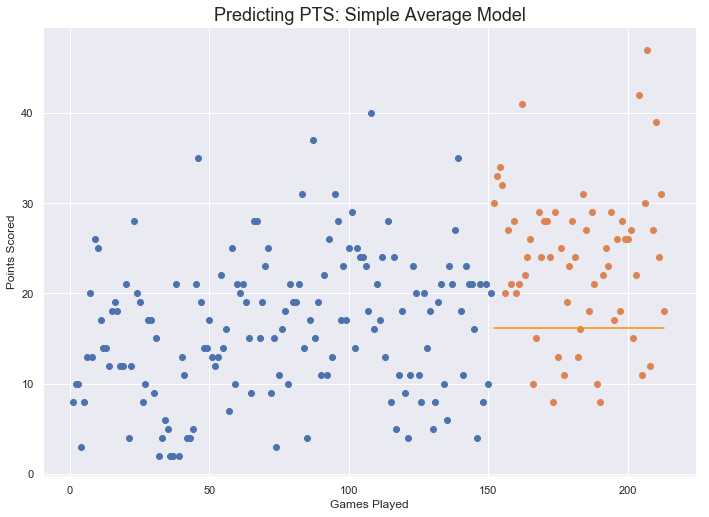

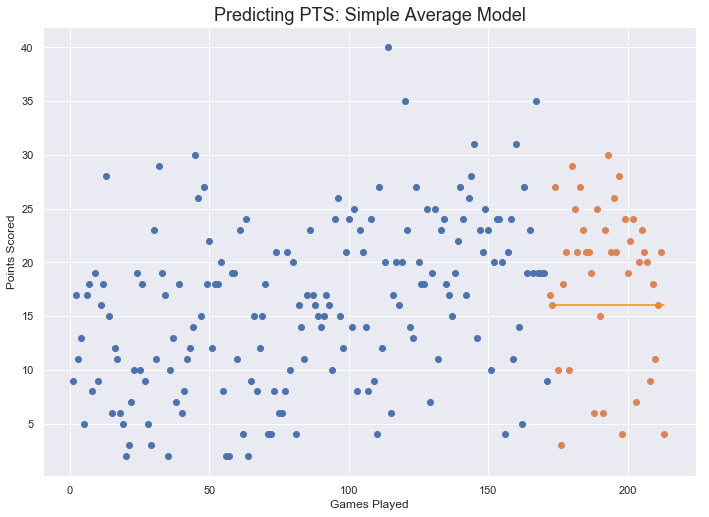

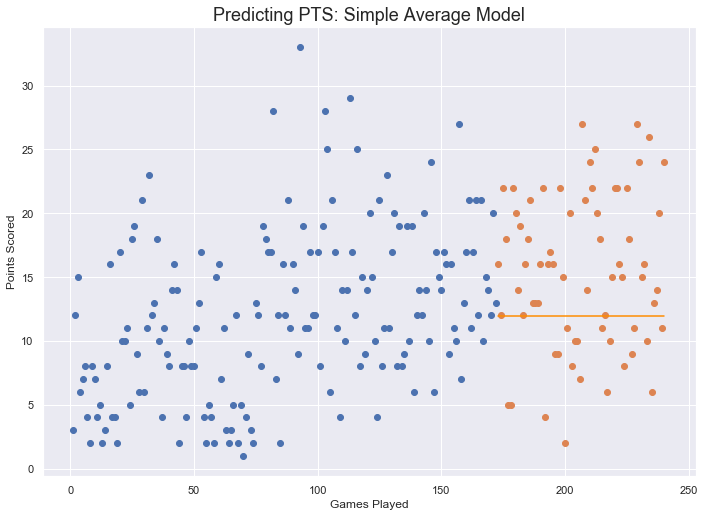

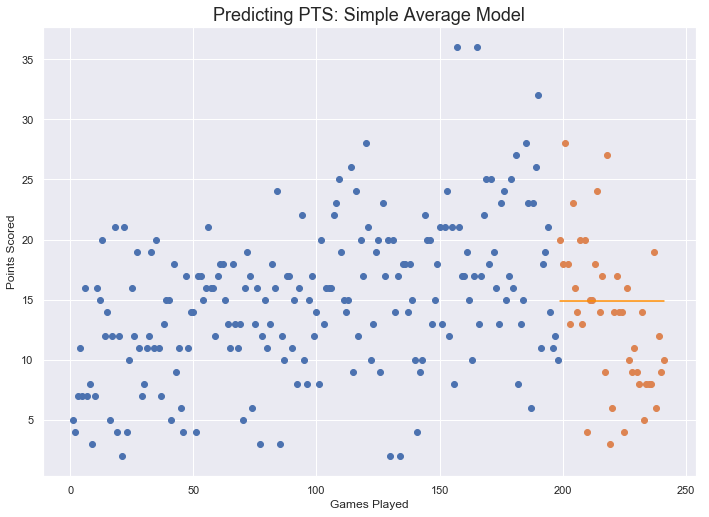

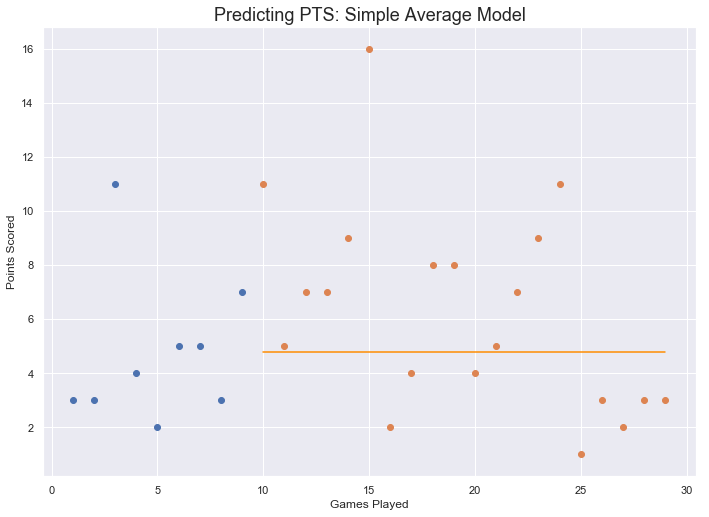

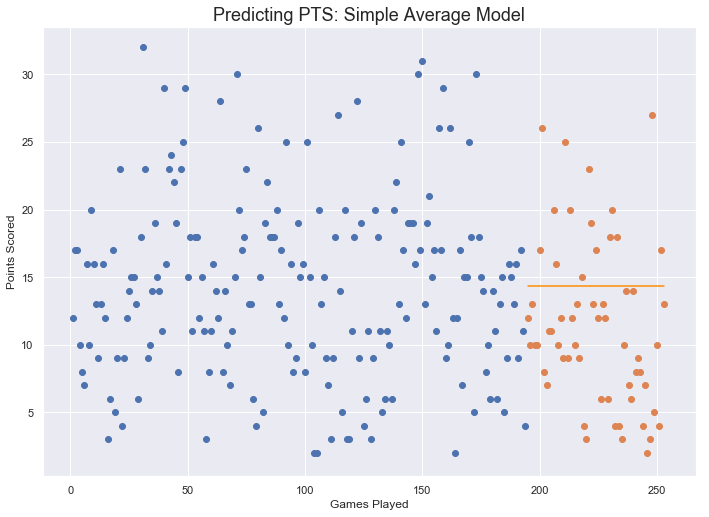

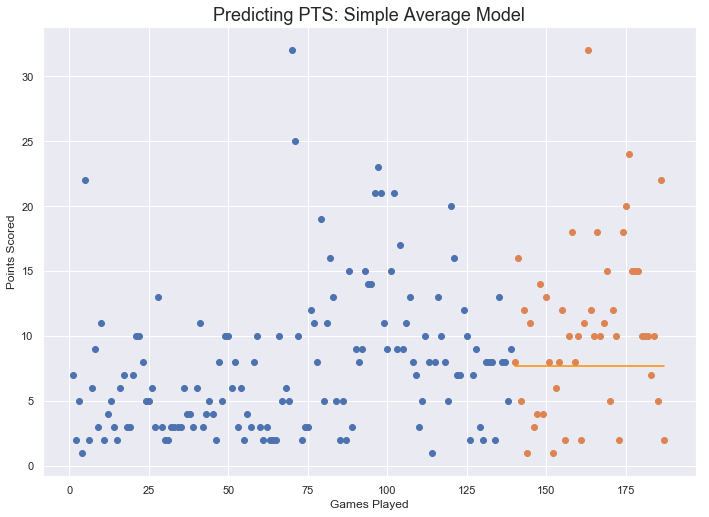

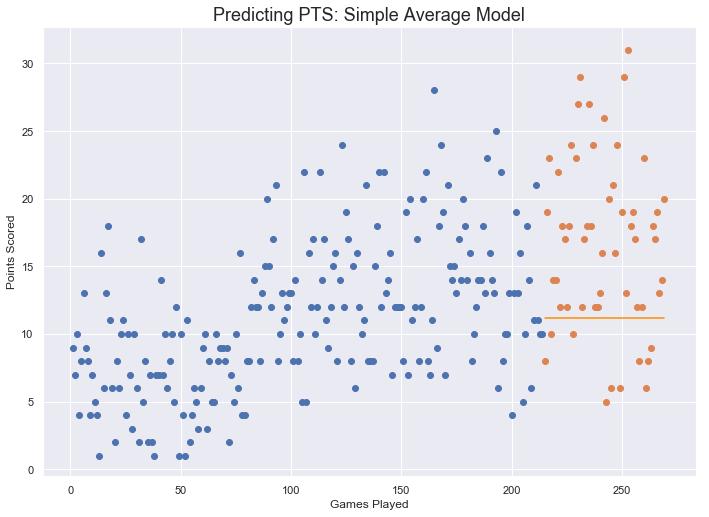

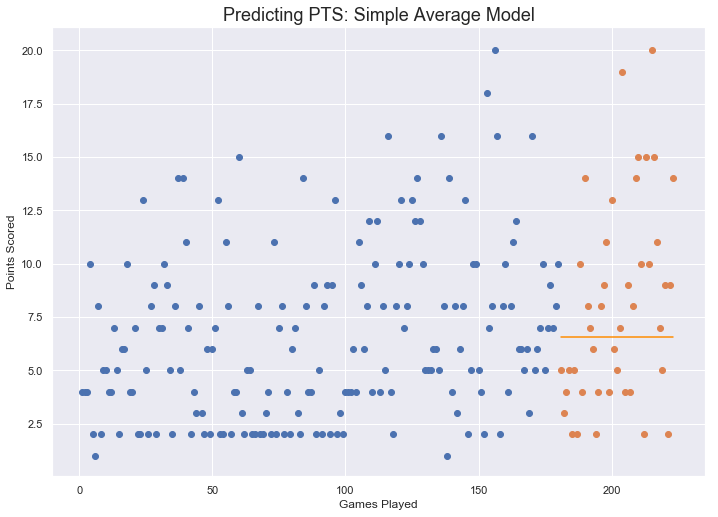

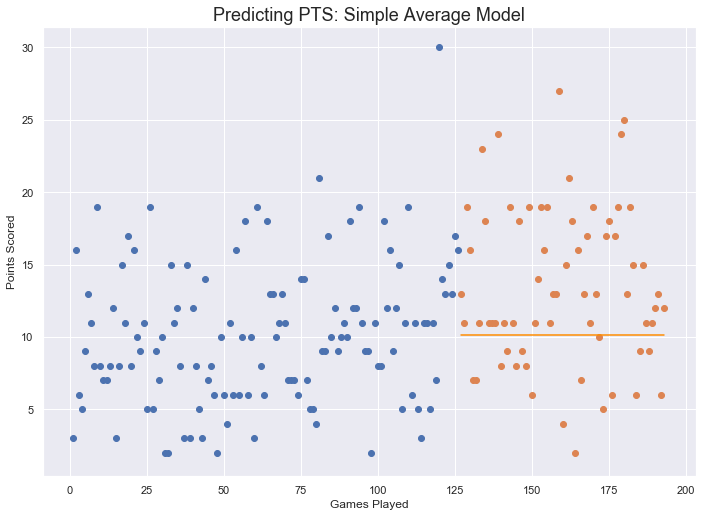

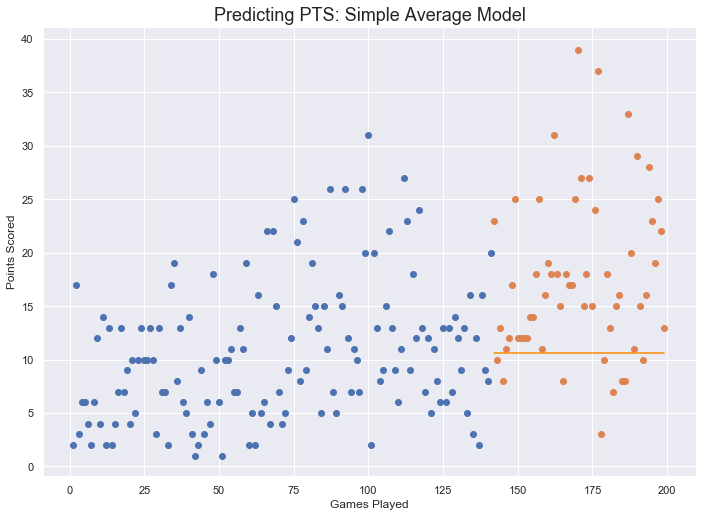

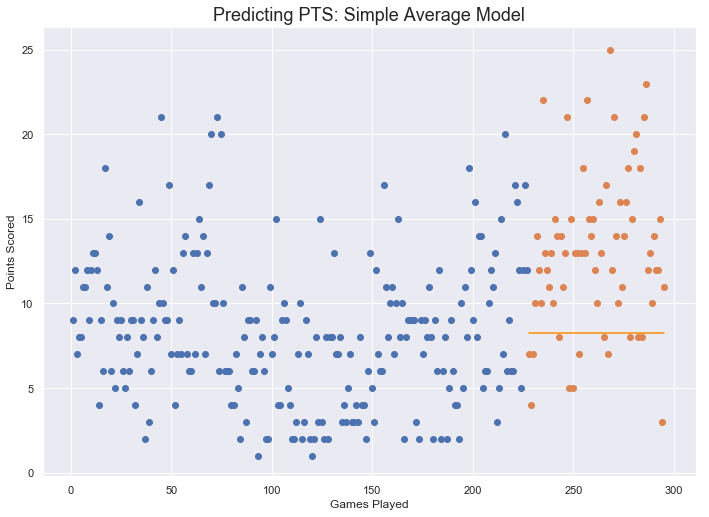

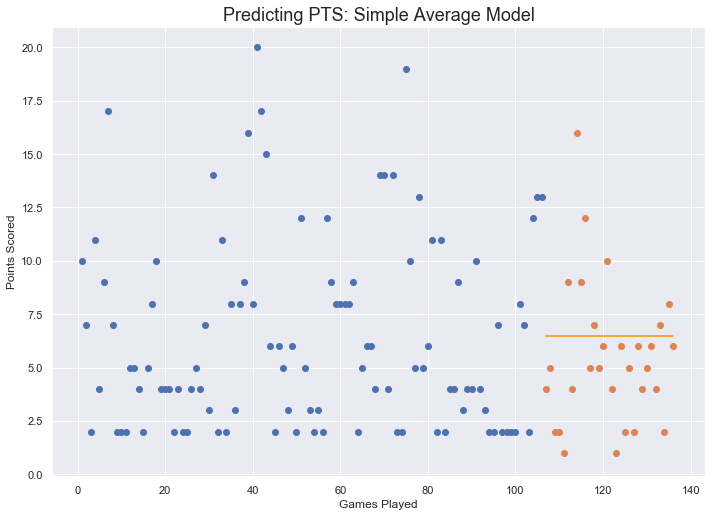

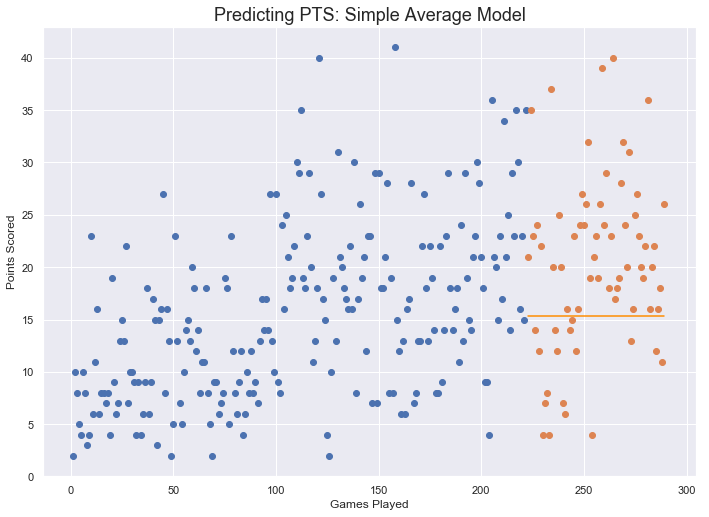

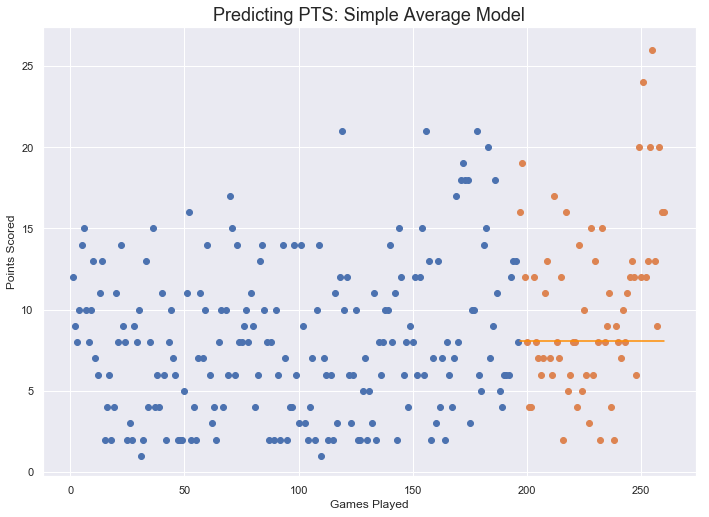

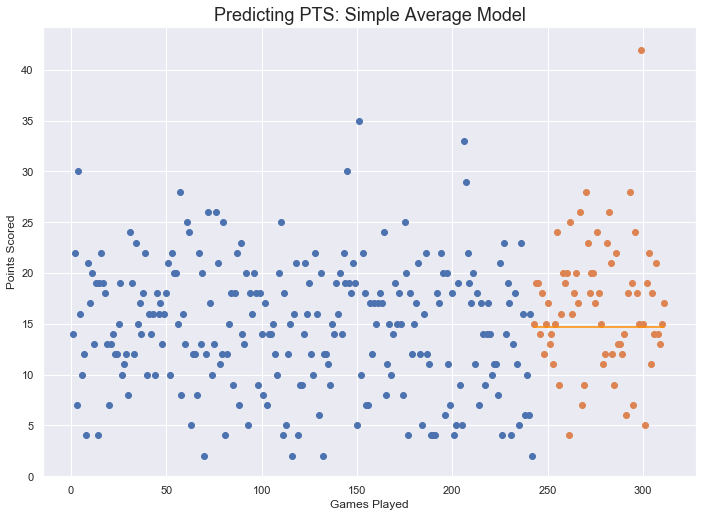

In [27]:
apply_model(sma)

In [14]:
"""
Mulit-feature Linear Regression
games played and dificulty of opponent
"""

total_rmse = []

for i in range (len(playerDF)):
    player = playerDF[i]
    features = ['Opp']
    points = ['PTS']
    x_hat = player[features]
    y_hat = player[points]

    x = np.array(x_hat)
    y = np.array(y_hat)
    x = x.astype(int)
    y = y.astype(int)
    games_pl = len(x) + 1
    games = np.arange(1, games_pl)
    x_cols = np.column_stack((games, x))
    linreg2 = LinearRegression()
    reg = linreg2.fit(x_cols, y)
    
    tst = player2019DF[i]
    x_tst = tst['Opp']
    y_tst = tst['PTS']
    x_tst = np.array(x_tst).astype(int)
    y_tst = np.array(y_tst).astype(int)
    
    games_tst = len(x_tst) + 1
    games_pl_tst = np.arange(games_pl,games_pl + games_tst-1)
    x_tst_cols = np.column_stack((games_pl_tst, x_tst))
    predicted_points = reg.predict(x_tst_cols)
    predicted_points = predicted_points.flatten()
    rmse = sqrt(mean_squared_error(predicted_points, y_tst))
    print("Classifier: player {0} rmse is: {1}".format(players[i], rmse))
    total_rmse.append(rmse)
    
np.mean(total_rmse)


Classifier: player w/wiggian01 rmse is: 7.1999542873256095
Classifier: player p/parkeja01 rmse is: 7.9130464149360105
Classifier: player e/embiijo01 rmse is: 8.713891904262804
Classifier: player g/gordoaa01 rmse is: 7.670420358734767
Classifier: player e/exumda01 rmse is: 5.03042664953128
Classifier: player s/smartma01 rmse is: 6.134211913906026
Classifier: player r/randlju01 rmse is: 7.591367814357249
Classifier: player s/stausni01 rmse is: 4.497979081938552
Classifier: player v/vonleno01 rmse is: 5.197435827585466
Classifier: player p/paytoel01 rmse is: 6.260676362671423
Classifier: player m/mcderdo01 rmse is: 4.847534963085634
Classifier: player l/lavinza01 rmse is: 8.998343068425637
Classifier: player w/warretj01 rmse is: 9.013550804035797
Classifier: player n/nurkiju01 rmse is: 6.609173899118361
Classifier: player h/harriga01 rmse is: 9.125619829032177
Classifier: player c/cabocbr01 rmse is: 4.6118324408475795
Classifier: player h/hoodro01 rmse is: 6.359683344733611
Classifier: pl

6.676398285638016

In [15]:
"""
Mulit-feature Linear Regression
games played and previous four games - maybe add oppt difficulty and see if that
improves the rmse -> doubtful!
"""


rmse_avg = []
rmse_avg2 = []
for i in range(len(playerDF)):
    train = playerDF[i]
    train = train[train.PTS != 0]
    features = ['PTS']
    train = train[features].apply(pd.to_numeric, errors='coerce')
    y = np.array(train).flatten()
    y_hat = y[2:]
    x_features = []
    for k in range(2,len(y)):
        temp = np.ones(2)
        for j in range(2):
            temp[j] = y[k-(j+1)]
        x_features.append(temp)
    games = np.arange(3, 3 + len(y_hat))
    x_cols = np.column_stack((games, x_features))
    
    tst = player2019DF[i]
    tst = tst[tst.PTS != 0]
    tst_feat = ['PTS']
    tst = tst[tst_feat].apply(pd.to_numeric, errors='coerce')
    y_tst = np.array(tst).flatten()
    y_hat_tst = y_tst[2:]

    x_tst = []
    for k in range(2, len(y_tst)):
        temp = np.ones(2)
        for j in range(2):
            temp[j] = y_tst[k-(j+1)]
        x_tst.append(temp)

    games_tst = np.arange(games[-1] + 3, (games[-1] + 3) + len(y_hat_tst))
    x_tst_cols = np.column_stack((games_tst,x_tst))

    linreg3 = LinearRegression()
    krr = KernelRidge(alpha=0.5, kernel='rbf', gamma=0.00001, degree=3, coef0=1, kernel_params=None)
    reg = linreg3.fit(x_cols, y_hat)
    kernel = krr.fit(x_cols, y_hat)
    predicted_points = reg.predict(x_tst_cols)
    pp2 = kernel.predict(x_tst_cols)
    rmse = sqrt(mean_squared_error(predicted_points,y_hat_tst))
    rmse2 = sqrt(mean_squared_error(pp2, y_hat_tst))
#     print("Classifier: player {0} rmse is: {1}".format(players[i], rmse))
    rmse_avg.append(rmse)
    rmse_avg2.append(rmse2)

np.mean(rmse_avg), np.mean(rmse_avg2)

(6.618163986768074, 6.259018637768033)

10.575767615248411


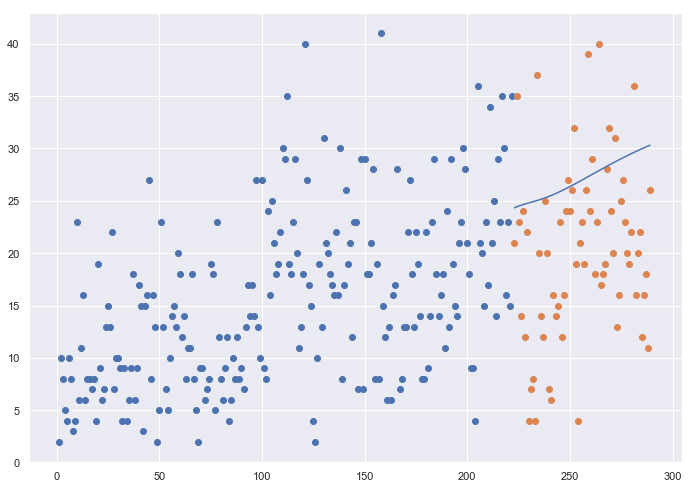

In [16]:
## vector auto_regression
## unsupervised kernel regression!
## gaussian process - single feature, time vs ppg!
from kernel_regression import KernelRegression

#Kernel Regression in progress!
# revise the gamma parameter - in progress!
# loop for all players - obtain csv
kr = KernelRegression(kernel="rbf", gamma=np.logspace(-2, 2, 2))

jokic = playerDF[24]
jokic = jokic.apply(pd.to_numeric,errors='coerce')
jokic = jokic[jokic.PTS != 0]
jokic = np.array(jokic.PTS)

no_of_games = len(jokic)
games = np.arange(1, no_of_games + 1)
games = games.reshape(-1,1)

kr_prime = kr.fit(games, jokic)

tst = player2019DF[24]
tst = tst.apply(pd.to_numeric,errors='coerce')
tst = tst[tst.PTS != 0]
tst = np.array(tst.PTS)

games_tst = len(tst)
x_tst = np.arange(no_of_games+1,(no_of_games+1) + games_tst)
x_tst = x_tst.reshape(-1,1)

opt = kr_prime.predict(x_tst)

rmse = sqrt(mean_squared_error(opt, tst))
print(rmse)

plt.scatter(games, jokic)
plt.scatter(x_tst, tst)
plt.plot(x_tst, opt)

In [17]:
"""
Multi-feature Kernel Regression
~~~~~~~~~~~~~~~~~~~~~~~~~~

Using the previous game's FGA attempts, previous GmSc,
game no. and the pts scoredfrom the previous 3 games as 
feautures to predict the points scored for the
upcoming game.

"""
a = []
ppg_avg = []
a2 = []
for i in range(len(playerDF)):
    train = playerDF[i]
    train = train[train.PTS != 0]
    train = train['PTS'].apply(pd.to_numeric, errors='coerce')
    y = np.array(train).flatten()
    y_hat = y[3:]
    x_features = []
    for k in range (3,len(y)):
        temp = np.ones(3)
        for j in range(3):
            temp[j] = y[k-(j+1)]
        x_features.append(temp)
    games = np.arange(4, 4 + len(y_hat))
    x_cols = np.column_stack((games, x_features))
    
    train = playerDF[i]
    train = train[train.PTS != 0]
    features = ['PTS', 'GmSc','FGA']
    train = train[features].apply(pd.to_numeric, errors='coerce')

    pts = np.array(train.PTS)
    gmsc = np.array(train.GmSc)
    fga = np.array(train.FGA)
    #prev game gmsc
    pts_i = pts[1:]
    gmsc_prev_i = gmsc[2:-1]
    fga_prev_i = fga[2:-1]
#     opp_cur = opp[3:]

    x_train = np.column_stack((x_cols, fga_prev_i, gmsc_prev_i))
    
    test = player2019DF[i]
    test = test[test.PTS != 0]
    test = test['PTS'].apply(pd.to_numeric, errors='coerce')
    y_tst = np.array(test).flatten()
    y_hat_tst = y_tst[3:]
    x_tst = []
    for k in range (3,len(y_tst)):
        temp = np.ones(3)
        for j in range(3):
            temp[j] = y_tst[k-(j+1)]
        x_tst.append(temp)

    games_tst = np.arange(games[-1] + 4, (games[-1] + 4) + len(y_hat_tst))
    x_tst_cols = np.column_stack((games_tst, x_tst))

    test = player2019DF[i]
    test = test[test.PTS != 0]
    features = ['PTS', 'GmSc','FGA']
    test = test[features].apply(pd.to_numeric, errors='coerce')

    pts = np.array(test.PTS)
    gmsc = np.array(test.GmSc)
    fga = np.array(test.FGA)
    #prev game gmsc
    pts_i = pts[1:]
    gmsc_prev_i = gmsc[2:-1]
    fga_prev_i = fga[2:-1]
#     opp_cur = opp[3:]

    x_test = np.column_stack((x_tst_cols, fga_prev_i, gmsc_prev_i))
    
    lr_clf = LinearRegression()
    krr_clf = KernelRidge(alpha=0.5, kernel='rbf', gamma=0.000007, degree=3, coef0=1, kernel_params=None)
    lr = lr_clf.fit(x_train, y_hat)
    clf = krr_clf.fit(x_train, y_hat)
    
    pred = clf.predict(x_test)
    lr_p = lr.predict(x_test)
    print("Player {0} average ppg:{1}".format(players[i],np.round(np.mean(pred),1)))
    ppg_avg.append(np.mean(pred))
    rmse = sqrt(mean_squared_error(pred, y_hat_tst))
    rmselr = sqrt(mean_squared_error(lr_p,y_hat_tst))
#     print(rmse)
    a.append(rmse)
    a2.append(rmselr)
    
print("Mean RMSE:{}".format(np.mean(a)))
# print("lr mean rmse:{}".format(np.mean(a2)))

Player w/wiggian01 average ppg:14.7
Player p/parkeja01 average ppg:15.8
Player e/embiijo01 average ppg:22.3
Player g/gordoaa01 average ppg:18.4
Player e/exumda01 average ppg:7.3
Player s/smartma01 average ppg:10.1
Player r/randlju01 average ppg:18.8
Player s/stausni01 average ppg:7.7
Player v/vonleno01 average ppg:6.5
Player p/paytoel01 average ppg:12.9
Player m/mcderdo01 average ppg:6.6
Player l/lavinza01 average ppg:18.1
Player w/warretj01 average ppg:20.8
Player n/nurkiju01 average ppg:15.9
Player h/harriga01 average ppg:18.6
Player c/cabocbr01 average ppg:4.0
Player h/hoodro01 average ppg:12.4
Player n/napiesh01 average ppg:10.1
Player c/capelca01 average ppg:14.6
Player a/anderky01 average ppg:8.3
Player h/harrijo01 average ppg:11.8
Player d/dinwisp01 average ppg:13.5
Player g/grantje01 average ppg:9.3
Player r/robingl02 average ppg:6.4
Player j/jokicni01 average ppg:21.0
Player p/poweldw01 average ppg:9.9
Player c/clarkjo01 average ppg:11.9
Mean RMSE:6.274673794249616


[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222]


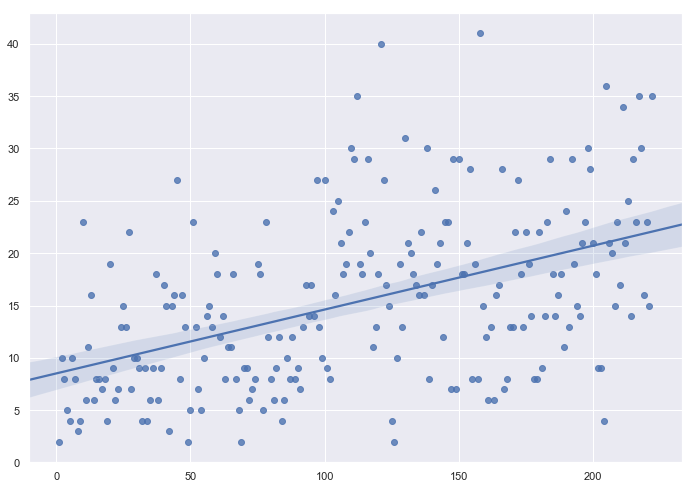

In [18]:
"""
Weighted Least Squares Regression
~~~~~~~~~~~~~~~~~~~~~~~~~~

WLS model, starting with one feature (games played), then build
from there

"""
# player: nikola jokic 
train = playerDF[24]
train = train[train.PTS != 0]
train = train['PTS']
y = np.array(train)

games_played = np.arange(1, len(train)+1)

x = games_played
gp = len(x)
print(x)
sns.regplot(x,y)

In [19]:
rmse_avg = []
rmse_avg_krr = []

for i in range(len(playerDF)):
    # player: nikola jokic
#     plt.figure(i)
    train = playerDF[i]
    train = train[train.PTS != 0]
    train = train['PTS']
    y = np.array(train)

    games_played = np.arange(1, len(train)+1)

    x = games_played
    gp = len(x)
    # print(x)
    # sns.regplot(x,y)


    # x = gamesplayed, y = points scored
    x1 = x.reshape(-1,1)
    y1 = y.reshape(-1,1)
    WLS = LinearRegression()
    WLS_k = KernelRidge(alpha=0.5, kernel='rbf', gamma=0.00001, degree=3, coef0=1, kernel_params=None)

    #add any weight right now
    sample_weights_low = [(t+80) for t in x]
#     print(len(sample_weights_low))
    wls_fit = WLS.fit(x1,y1, sample_weight=sample_weights_low)
    wls_k_fit = WLS_k.fit(x1,y1,sample_weight=sample_weights_low)

    test = player2019DF[i]
    test = test[test.PTS != 0]
    test = test['PTS']
    y_hat = np.array(test)
    g_no = len(y_hat)
    g_t = np.arange(gp+1,(gp+1) + g_no)
    x_tst = g_t
    x_tst = x_tst.reshape(-1,1)
    wls_predicted = wls_fit.predict(x_tst)
    krr_predicted = wls_k_fit.predict(x_tst)

    rmse = sqrt(mean_squared_error(wls_predicted, y_hat))
    rmse2 = sqrt(mean_squared_error(krr_predicted, y_hat))
    rmse_avg.append(rmse)
    rmse_avg_krr.append(rmse2)
#     print("player {0} rmse = {1}".format(players[i], rmse))
#     plt.scatter(x1,y1)
#     plt.plot(x1, wls_fit.predict(x1))
#     plt.scatter(x_tst,y_hat)
#     plt.plot(x_tst, wls_predicted)

print(np.mean(rmse_avg))
# print(np.mean(rmse_avg_krr))

6.3261900166723


In [22]:
players_ppg_2019= [18.1,14.5, 27.5, 16.0,6.9,8.9, 21.4,5.9,8.4,
                  10.6,7.3,23.7,18.0,15.6,12.9,8.3, 11.2,9.4,
                  16.6,8.0,13.7,16.8,13.6,4.2,20.1,10.6,16.8]

players_ppg_2019 = np.array(players_ppg_2019)
ppg_arr = np.array(ppg_avg)
print(np.mean(ppg_arr - players_ppg_2019))



-0.6391900391166782